In [1]:
import inspect
import os

import gym
from gym.envs.toy_text.frozen_lake import generate_random_map
from hiive.mdptoolbox import mdp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
for i in gym.envs.registry.all():
    if 'Frozen' in i.id:
        print(i)

EnvSpec(FrozenLake-v1)
EnvSpec(FrozenLake8x8-v1)


#### functions

In [3]:
def get_RP(env):
    P = np.zeros((env.nA, env.nS, env.nS))
    R_trans = np.zeros((env.nS, env.nA))
    R_true = np.zeros((env.nA, env.nS, env.nS))
    for s1 in range(env.nS):
        for a in range(env.nA):
            for p, s2, r, _ in env.P[s1][a]:
                P[a][s1][s2] += p
                R_trans[s1][a] += r * p
                R_true[a][s1][s2] += r
    return R_trans, R_true, P

In [4]:
def simulate_frozen_lake_policy(P, policy, n=10000, seed=42):
    rewards = []
    start = 0
    terminating_spots = set(np.where(P.max(axis=1) == 1)[1])
    np.random.seed(seed)
    for i in range(n):
#         print('Iter', i)
        reward = 0
        pos = start
        done = False
#         print(pos)
        while not done:
            action = policy[pos]
            p = np.random.uniform(0, 1)
            pos = (P[action][pos].cumsum() > p).argmax()
            if pos in terminating_spots:
                if pos == P.shape[1] - 1:
                    reward = 1
                done = True
#             print(action, pos, done)
        rewards.append(reward)
    return rewards

In [152]:
def save_results(results, keys=None, folder=None):
    if folder is None:
        folder = './results'
    if not os.path.exists(folder):
        os.mkdir(folder)
    if keys is None:
        keys = []
    for k, v in results.items():
        if isinstance(v, dict):
            save_results(v, keys + [str(k)], folder)
        else:
            path = os.path.join(folder, '_'.join(keys + [str(k)]) + '.csv')
            if isinstance(v, pd.DataFrame):
                v.to_csv(path, index=False)
            elif isinstance(v, (list, tuple, np.array)):
                np.savetxt(path, v)
            else:
                print('ERROR', path)
    return

In [ ]:
def action_diffs(a1, a2):
    if a1 == a2:
        diff = (None, None)
    elif a1 == 0:
        if a2 == 1:
            diff = ('^', '>')
        elif a2 == 2:
            diff = ('<', '>')
        elif a2 == 3:
            diff = ('v', '>')
    elif a1 == 1:
        if a2 == 0:
            diff = ('>', '^')
        elif a2 == 2:
            diff = ('<', '^')
        elif a2 == 3:
            diff = ('v', '^')
    elif a1 == 2:
        if a2 == 0:
            diff = ('>', '<')
        elif a2 == 1:
            diff = ('^', '<')
        elif a2 == 3:
            diff = ('v', '<')
    elif a1 == 3:
        if a2 == 0:
            diff = ('>', 'v')
        elif a2 == 1:
            diff = ('^', 'v')
        elif a2 == 2:
            diff = ('<', 'v')
    return diff

In [ ]:
def move(loc, a, size):
    max_c = {'small': 7, 'large': 15}[size]
    max_r = max_c
    r, c = loc
    if a == '^':
        r = max(r-1, 0)
    elif a == '>':
        c = min(c+1, max_c)
    elif a == 'v':
        r = min(r+1, max_r)
    elif a == '<':
        c = max(c-1, 0)
    return (r, c)

In [ ]:
action_map = {
    0: '<',
    1: 'v',
    2: '>',
    3: '^'
}

#### setup problems

In [5]:
results = {}
policies = {}
simulations = {}

#### frozen lake

In [6]:
prob = 'frozen_lake'
sizes = {'small': 8, 'large': 16}
results.setdefault(prob, {})
policies.setdefault(prob, {})
simulations.setdefault(prob, {})
envs = {}
P = {}
R_trans = {}
R_true = {}

In [7]:
np.random.seed(42)
for size in sizes:
    env_map = generate_random_map(size=sizes[size], p=.8)
    envs[size] = gym.make('FrozenLake-v1', desc=env_map)
    envs[size] = envs[size].unwrapped
    R_trans[size], R_true[size], P[size] = get_RP(envs[size])

In [156]:
mdp._util.getSpan = lambda x: abs(x).max()

In [210]:
# VI
method = 'value_iteration'
size = 'small'
results[prob].setdefault(size, {})
policies[prob].setdefault(size, {})
policies[prob][size].setdefault(method, {})
max_iter = int(1e7)
gammas = [.5, .9, .99, .999, .9999, .99999]
epsilons = [.5, .1, .05, .01, .005, .001]
df = []
for g in gammas:
    policies[prob][size][method].setdefault(g, {})
    for e in epsilons:
        print(f'Gamma: {g} \tEpsilon: {e}')
        VI = mdp.ValueIteration(P[size], R_trans[size], gamma=g, epsilon=e, max_iter=max_iter)
        VI.max_iter = max_iter
        VI.run_stat_frequency = 1
        scores = VI.run()
        for r in scores:
            df.append((prob, size, method, g, e, r['Error'], r['Iteration'], r['Time'], r['Mean V']))
        policies[prob][size][method][g][e] = [p.copy() for _, p in VI.p_cumulative]
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'gamma', 'epsilon', 'error', 'iter', 'time', 'mean_value'])
results[prob][size][method] = df.copy()

Gamma: 0.5 	Epsilon: 0.5
Gamma: 0.5 	Epsilon: 0.1
Gamma: 0.5 	Epsilon: 0.05
Gamma: 0.5 	Epsilon: 0.01
Gamma: 0.5 	Epsilon: 0.005
Gamma: 0.5 	Epsilon: 0.001
Gamma: 0.9 	Epsilon: 0.5
Gamma: 0.9 	Epsilon: 0.1
Gamma: 0.9 	Epsilon: 0.05
Gamma: 0.9 	Epsilon: 0.01
Gamma: 0.9 	Epsilon: 0.005
Gamma: 0.9 	Epsilon: 0.001
Gamma: 0.99 	Epsilon: 0.5
Gamma: 0.99 	Epsilon: 0.1
Gamma: 0.99 	Epsilon: 0.05
Gamma: 0.99 	Epsilon: 0.01
Gamma: 0.99 	Epsilon: 0.005
Gamma: 0.99 	Epsilon: 0.001
Gamma: 0.999 	Epsilon: 0.5
Gamma: 0.999 	Epsilon: 0.1
Gamma: 0.999 	Epsilon: 0.05
Gamma: 0.999 	Epsilon: 0.01
Gamma: 0.999 	Epsilon: 0.005
Gamma: 0.999 	Epsilon: 0.001
Gamma: 0.9999 	Epsilon: 0.5
Gamma: 0.9999 	Epsilon: 0.1
Gamma: 0.9999 	Epsilon: 0.05
Gamma: 0.9999 	Epsilon: 0.01
Gamma: 0.9999 	Epsilon: 0.005
Gamma: 0.9999 	Epsilon: 0.001
Gamma: 0.99999 	Epsilon: 0.5
Gamma: 0.99999 	Epsilon: 0.1
Gamma: 0.99999 	Epsilon: 0.05
Gamma: 0.99999 	Epsilon: 0.01
Gamma: 0.99999 	Epsilon: 0.005
Gamma: 0.99999 	Epsilon: 0.001


In [211]:
df.groupby(['gamma', 'epsilon'])['mean_value'].max().to_frame().unstack()

mean_value                                                  
epsilon      0.001     0.005     0.010     0.050     0.100     0.500
gamma                                                               
0.50000   0.008681  0.008484  0.008247  0.007812  0.006944  0.005208
0.90000   0.055257  0.053452  0.051571  0.038026  0.027924  0.013677
0.99000   0.399338  0.399082  0.398751  0.395833  0.391918  0.341020
0.99900   0.606452  0.606416  0.606371  0.606009  0.605548  0.601781
0.99990   0.638955  0.638948  0.638938  0.638863  0.638770  0.638111
0.99999   0.643436  0.643435  0.643434  0.643423  0.643411  0.643309

In [212]:
df.groupby(['gamma', 'epsilon'])['iter'].max().to_frame().unstack()

iter                              
epsilon 0.001 0.005 0.010 0.050 0.100 0.500
gamma                                      
0.50000     7     5     4     3     2     1
0.90000    46    33    28    15    10     4
0.99000   263   218   198   150   129    70
0.99900   448   386   359   297   270   207
0.99990   669   576   537   445   406   320
0.99999   906   797   750   640   593   483

In [213]:
simulations[prob].setdefault(size, {})
df = []
n = 1000
i = 0
for g in gammas:
    for e in epsilons:
        print(f'Gamma: {g} \tEpsilon: {e}')
        r = simulate_frozen_lake_policy(P[size], policies[prob][size][method][g][e][-1], n, 42*i)
        df.append((prob, size, method, g, e, i, sum(r)/n))
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'gamma', 'epsilon', 'run', 'avg_reward'])
simulations[prob][size][method] = df.copy()

Gamma: 0.5 	Epsilon: 0.5
Gamma: 0.5 	Epsilon: 0.1
Gamma: 0.5 	Epsilon: 0.05
Gamma: 0.5 	Epsilon: 0.01
Gamma: 0.5 	Epsilon: 0.005
Gamma: 0.5 	Epsilon: 0.001
Gamma: 0.9 	Epsilon: 0.5
Gamma: 0.9 	Epsilon: 0.1
Gamma: 0.9 	Epsilon: 0.05
Gamma: 0.9 	Epsilon: 0.01
Gamma: 0.9 	Epsilon: 0.005
Gamma: 0.9 	Epsilon: 0.001
Gamma: 0.99 	Epsilon: 0.5
Gamma: 0.99 	Epsilon: 0.1
Gamma: 0.99 	Epsilon: 0.05
Gamma: 0.99 	Epsilon: 0.01
Gamma: 0.99 	Epsilon: 0.005
Gamma: 0.99 	Epsilon: 0.001
Gamma: 0.999 	Epsilon: 0.5
Gamma: 0.999 	Epsilon: 0.1
Gamma: 0.999 	Epsilon: 0.05
Gamma: 0.999 	Epsilon: 0.01
Gamma: 0.999 	Epsilon: 0.005
Gamma: 0.999 	Epsilon: 0.001
Gamma: 0.9999 	Epsilon: 0.5
Gamma: 0.9999 	Epsilon: 0.1
Gamma: 0.9999 	Epsilon: 0.05
Gamma: 0.9999 	Epsilon: 0.01
Gamma: 0.9999 	Epsilon: 0.005
Gamma: 0.9999 	Epsilon: 0.001
Gamma: 0.99999 	Epsilon: 0.5
Gamma: 0.99999 	Epsilon: 0.1
Gamma: 0.99999 	Epsilon: 0.05
Gamma: 0.99999 	Epsilon: 0.01
Gamma: 0.99999 	Epsilon: 0.005
Gamma: 0.99999 	Epsilon: 0.001


In [214]:
df.groupby(['gamma', 'epsilon'])['avg_reward'].mean().unstack()

epsilon,0.001,0.005,0.010,0.050,0.100,0.500
gamma,,,,,,
0.50000,0.000,0.000,0.000,0.000,0.000,0.000
0.90000,0.943,0.943,0.943,0.943,0.000,0.000
0.99000,0.955,0.955,0.955,0.955,0.955,0.955
0.99900,0.965,0.965,0.965,0.965,0.965,0.965
0.99990,0.964,0.964,0.964,0.964,0.964,0.964
0.99999,0.969,0.969,0.969,0.969,0.969,0.969


In [373]:
envs['small'].render()
for g in [.9, .99, .999, .9999, .99999]:
    print(g)
    diff = np.where(
        policies[prob]['small']['value_iteration'][g][.001][-1].reshape(8,8) !=
        policies[prob]['small']['value_iteration'][.99999][.001][-1].reshape(8,8)
    )
    for r, c in zip(*diff):
        if envs['small'].desc[r][c] in (b'HG'):
            continue
        a1 = policies[prob]['small']['value_iteration'][g][.001][-1].reshape(8,8)[r][c]
        a2 = policies[prob]['small']['value_iteration'][.99999][.001][-1].reshape(8,8)[r][c]
        a1_diff, a2_diff = action_diffs(a1, a2) 
        l1 = move((r, c), a1_diff, 'small')
        l2 = move((r, c), a2_diff, 'small')
        if envs['small'].desc[l1] == b'H' and envs['small'].desc[l2] == b'H':
            continue
        print(
            (r,c), 
            action_map[policies[prob]['small']['value_iteration'][g][.001][-1].reshape(8,8)[r][c]],
            action_map[policies[prob]['small']['value_iteration'][.99999][.001][-1].reshape(8,8)[r][c]]
        )
    print('')


SFFHFHFF
FHFFFFFF
HFFFFFFF
HFFFFFFF
FFFFFFFF
HFFFFFFF
HHFHHFHF
HHFFFFHG
0.9
(1, 6) v >
(1, 7) v >
(2, 5) v >
(2, 6) v >
(2, 7) v >
(3, 6) v >
(3, 7) v >
(4, 7) v >

0.99
(1, 7) v >
(2, 6) v >
(2, 7) v >
(3, 7) v >
(4, 7) v >

0.999
(1, 7) v >
(2, 7) v >
(3, 7) v >

0.9999
(1, 7) v >

0.99999



In [218]:
# VI
method = 'value_iteration'
size = 'large'
results[prob].setdefault(size, {})
policies[prob].setdefault(size, {})
policies[prob][size].setdefault(method, {})
max_iter = int(1e7)
gammas = [.5, .9, .99, .999, .9999, .99999]
epsilons = [.5, .1, .05, .01, .005, .001]
df = []
for g in gammas:
    policies[prob][size][method].setdefault(g, {})
    for e in epsilons:
        print(f'Gamma: {g} \tEpsilon: {e}')
        VI = mdp.ValueIteration(P[size], R_trans[size], gamma=g, epsilon=e, max_iter=max_iter)
        VI.max_iter = max_iter
        VI.run_stat_frequency = 1
        scores = VI.run()
        for r in scores:
            df.append((prob, size, method, g, e, r['Error'], r['Iteration'], r['Time'], r['Mean V']))
        policies[prob][size][method][g][e] = [p.copy() for _, p in VI.p_cumulative]
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'gamma', 'epsilon', 'error', 'iter', 'time', 'mean_value'])
results[prob][size][method] = df.copy()

Gamma: 0.5 	Epsilon: 0.5
Gamma: 0.5 	Epsilon: 0.1
Gamma: 0.5 	Epsilon: 0.05
Gamma: 0.5 	Epsilon: 0.01
Gamma: 0.5 	Epsilon: 0.005
Gamma: 0.5 	Epsilon: 0.001
Gamma: 0.9 	Epsilon: 0.5
Gamma: 0.9 	Epsilon: 0.1
Gamma: 0.9 	Epsilon: 0.05
Gamma: 0.9 	Epsilon: 0.01
Gamma: 0.9 	Epsilon: 0.005
Gamma: 0.9 	Epsilon: 0.001
Gamma: 0.99 	Epsilon: 0.5
Gamma: 0.99 	Epsilon: 0.1
Gamma: 0.99 	Epsilon: 0.05
Gamma: 0.99 	Epsilon: 0.01
Gamma: 0.99 	Epsilon: 0.005
Gamma: 0.99 	Epsilon: 0.001
Gamma: 0.999 	Epsilon: 0.5
Gamma: 0.999 	Epsilon: 0.1
Gamma: 0.999 	Epsilon: 0.05
Gamma: 0.999 	Epsilon: 0.01
Gamma: 0.999 	Epsilon: 0.005
Gamma: 0.999 	Epsilon: 0.001
Gamma: 0.9999 	Epsilon: 0.5
Gamma: 0.9999 	Epsilon: 0.1
Gamma: 0.9999 	Epsilon: 0.05
Gamma: 0.9999 	Epsilon: 0.01
Gamma: 0.9999 	Epsilon: 0.005
Gamma: 0.9999 	Epsilon: 0.001
Gamma: 0.99999 	Epsilon: 0.5
Gamma: 0.99999 	Epsilon: 0.1
Gamma: 0.99999 	Epsilon: 0.05
Gamma: 0.99999 	Epsilon: 0.01
Gamma: 0.99999 	Epsilon: 0.005
Gamma: 0.99999 	Epsilon: 0.001


In [219]:
df.groupby(['gamma', 'epsilon'])['mean_value'].max().to_frame().unstack()

mean_value                                                  
epsilon      0.001     0.005     0.010     0.050     0.100     0.500
gamma                                                               
0.50000   0.002128  0.002096  0.002050  0.001953  0.001736  0.001302
0.90000   0.008328  0.007792  0.007451  0.006156  0.005485  0.003349
0.99000   0.116440  0.115450  0.114200  0.103387  0.090136  0.020826
0.99900   0.413087  0.412557  0.411910  0.406837  0.400663  0.356031
0.99990   0.574712  0.574634  0.574537  0.573757  0.572785  0.564990
0.99999   0.599380  0.599371  0.599360  0.599264  0.599142  0.598106

In [220]:
df.groupby(['gamma', 'epsilon'])['iter'].max().to_frame().unstack()

iter                              
epsilon 0.001 0.005 0.010 0.050 0.100 0.500
gamma                                      
0.50000     7     5     4     3     2     1
0.90000    38    26    22    13    10     4
0.99000   378   290   252   159   119    28
0.99900  1944  1545  1374   978   811   442
0.99990  3602  3033  2788  2218  1973  1403
0.99999  5022  4347  4055  3372  3074  2374

In [221]:
simulations[prob].setdefault(size, {})
df = []
n = 1000
i = 0
for g in gammas:
    for e in epsilons:
        print(f'Gamma: {g} \tEpsilon: {e}')
        r = simulate_frozen_lake_policy(P[size], policies[prob][size][method][g][e][-1], n, 42*i)
        df.append((prob, size, method, g, e, i, sum(r)/n))
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'gamma', 'epsilon', 'run', 'avg_reward'])
simulations[prob][size][method] = df.copy()

Gamma: 0.5 	Epsilon: 0.5
Gamma: 0.5 	Epsilon: 0.1
Gamma: 0.5 	Epsilon: 0.05
Gamma: 0.5 	Epsilon: 0.01
Gamma: 0.5 	Epsilon: 0.005
Gamma: 0.5 	Epsilon: 0.001
Gamma: 0.9 	Epsilon: 0.5
Gamma: 0.9 	Epsilon: 0.1
Gamma: 0.9 	Epsilon: 0.05
Gamma: 0.9 	Epsilon: 0.01
Gamma: 0.9 	Epsilon: 0.005
Gamma: 0.9 	Epsilon: 0.001
Gamma: 0.99 	Epsilon: 0.5
Gamma: 0.99 	Epsilon: 0.1
Gamma: 0.99 	Epsilon: 0.05
Gamma: 0.99 	Epsilon: 0.01
Gamma: 0.99 	Epsilon: 0.005
Gamma: 0.99 	Epsilon: 0.001
Gamma: 0.999 	Epsilon: 0.5
Gamma: 0.999 	Epsilon: 0.1
Gamma: 0.999 	Epsilon: 0.05
Gamma: 0.999 	Epsilon: 0.01
Gamma: 0.999 	Epsilon: 0.005
Gamma: 0.999 	Epsilon: 0.001
Gamma: 0.9999 	Epsilon: 0.5
Gamma: 0.9999 	Epsilon: 0.1
Gamma: 0.9999 	Epsilon: 0.05
Gamma: 0.9999 	Epsilon: 0.01
Gamma: 0.9999 	Epsilon: 0.005
Gamma: 0.9999 	Epsilon: 0.001
Gamma: 0.99999 	Epsilon: 0.5
Gamma: 0.99999 	Epsilon: 0.1
Gamma: 0.99999 	Epsilon: 0.05
Gamma: 0.99999 	Epsilon: 0.01
Gamma: 0.99999 	Epsilon: 0.005
Gamma: 0.99999 	Epsilon: 0.001


In [222]:
df.groupby(['gamma', 'epsilon'])['avg_reward'].mean().unstack()

epsilon,0.001,0.005,0.010,0.050,0.100,0.500
gamma,,,,,,
0.50000,0.000,0.000,0.000,0.000,0.000,0.000
0.90000,0.072,0.000,0.000,0.000,0.000,0.000
0.99000,0.161,0.161,0.161,0.144,0.144,0.027
0.99900,0.342,0.342,0.342,0.336,0.336,0.308
0.99990,0.353,0.353,0.353,0.353,0.353,0.366
0.99999,0.360,0.360,0.360,0.360,0.360,0.362


In [227]:
# PI
method = 'policy_iteration'
size = 'small'
results[prob].setdefault(size, {})
policies[prob].setdefault(size, {})
policies[prob][size].setdefault(method, {})
max_iter = int(1e2)
gammas = [.5, .9, .99, .999, .9999, .99999]
df = []
for g in gammas:
    print(f'Gamma: {g}')
    PI = mdp.PolicyIteration(P[size], R_trans[size], gamma=g, max_iter=max_iter)
    scores = PI.run()
    for r in scores:
        df.append((prob, size, method, g, r['Error'], r['Iteration'], r['Time'], r['Mean V']))
    policies[prob][size][method][g] = [p.copy() for _, p in PI.p_cumulative]
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'gamma', 'error', 'iter', 'time', 'mean_value'])
results[prob][size][method] = df.copy()

Gamma: 0.5
Gamma: 0.9
Gamma: 0.99
Gamma: 0.999
Gamma: 0.9999
Gamma: 0.99999


In [15]:
df.groupby('gamma')['mean_value'].max().to_frame()

,mean_value
gamma,
0.50000,0.008766
0.90000,0.055697
0.99000,0.399402
0.99900,0.606461
0.99990,0.638957
0.99999,0.643436


In [16]:
df.groupby('gamma')['iter'].max().to_frame()

,iter
gamma,
0.50000,9
0.90000,5
0.99000,100
0.99900,4
0.99990,100
0.99999,100


In [174]:
simulations[prob].setdefault(size, {})
df = []
n = 1000
i = 0
for g in gammas:
    print(f'Gamma: {g}')
    r = simulate_frozen_lake_policy(P[size], policies[prob][size][method][g][-1], n, 42*i)
    df.append((prob, size, method, g, i, sum(r)/n))
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'gamma', 'run', 'avg_reward'])
simulations[prob][size][method] = df.copy()

Gamma: 0.5
Gamma: 0.9
Gamma: 0.99
Gamma: 0.999
Gamma: 0.9999
Gamma: 0.99999


In [175]:
df.groupby(['gamma'])['avg_reward'].mean().to_frame()

,avg_reward
gamma,
0.50000,0.943
0.90000,0.943
0.99000,0.948
0.99900,0.965
0.99990,0.964
0.99999,0.965


In [17]:
# PI
method = 'policy_iteration'
size = 'large'
results[prob].setdefault(size, {})
policies[prob].setdefault(size, {})
policies[prob][size].setdefault(method, {})
max_iter = int(1e2)
gammas = [.5, .9, .99, .999, .9999, .99999]
df = []
for g in gammas:
    print(f'Gamma: {g}')
    PI = mdp.PolicyIteration(P[size], R_trans[size], gamma=g, max_iter=max_iter)
    scores = PI.run()
    for r in scores:
        df.append((prob, size, method, g, r['Error'], r['Iteration'], r['Time'], r['Mean V']))
    policies[prob][size][method][g] = [p.copy() for _, p in PI.p_cumulative]
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'gamma', 'error', 'iter', 'time', 'mean_value'])
results[prob][size][method] = df.copy()

Gamma: 0.5
Gamma: 0.9
Gamma: 0.99
Gamma: 0.999
Gamma: 0.9999
Gamma: 0.99999


In [18]:
df.groupby('gamma')['mean_value'].max().to_frame()

,mean_value
gamma,
0.50000,0.002139
0.90000,0.008584
0.99000,0.116676
0.99900,0.413221
0.99990,0.574731
0.99999,0.599383


In [19]:
df.groupby('gamma')['iter'].max().to_frame()

,iter
gamma,
0.50000,17
0.90000,11
0.99000,100
0.99900,100
0.99990,100
0.99999,100


In [183]:
simulations[prob].setdefault(size, {})
df = []
n = 1000
i = 0
for g in gammas:
    print(f'Gamma: {g}')
    r = simulate_frozen_lake_policy(P[size], policies[prob][size][method][g][-1], n, 42*i)
    df.append((prob, size, method, g, i, sum(r)/n))
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'gamma', 'run', 'avg_reward'])
simulations[prob][size][method] = df.copy()

Gamma: 0.5
Gamma: 0.9
Gamma: 0.99
Gamma: 0.999
Gamma: 0.9999
Gamma: 0.99999


In [185]:
df.groupby(['gamma'])['avg_reward'].mean().to_frame()

,avg_reward
gamma,
0.50000,0.047
0.90000,0.087
0.99000,0.156
0.99900,0.346
0.99990,0.340
0.99999,0.356


In [197]:
from scipy.stats import ttest_ind

In [199]:
ttest_ind([1]*353 + [0]*(1000-353), [1]*340 + [0]*(1000-340))

Ttest_indResult(statistic=0.6106286871460285, pvalue=0.541514878775222)

In [22]:
# Q - gamma tuning
method = 'q_learning'
size = 'small'
param = 'gamma'
results[prob].setdefault(size, {})
results[prob][size].setdefault(method, {})
policies[prob].setdefault(size, {})
policies[prob][size].setdefault(method, {})
policies[prob][size][method].setdefault(param, {})
n_iter = int(1e5)
gammas = [.5, .9, .99, .999, .9999, .99999]
runs = range(5)
a_0 = 1
a = .9999
e_0 = 1
e = .9999
iter_callback = lambda x, y, z: envs[size].desc[z//sizes[size], z%sizes[size]] in b'GH'
df = []
for g in gammas:
    policies[prob][size][method][param].setdefault(g, {})
    for i in runs:
        print(f'Gamma: {g} \tRun: {i}')
        np.random.seed(42*i)
        QL = mdp.QLearning(
            P[size],
            R_true[size],
            gamma=g,
            alpha=a_0,
            alpha_decay=a,
            epsilon=e_0,
            epsilon_decay=e,
            iter_callback=iter_callback,
            n_iter=n_iter
        )
        scores = QL.run()
        for r in scores:
            df.append((
                prob, size, method, g, i, r['Epsilon'], e, r['Alpha'], a, r['Iteration'], r['Time'], r['Mean V'],
                r['Error']
            ))
        policies[prob][size][method][param][g][i] = [p.copy() for _, p in QL.p_cumulative]
cols = [
    'prob', 'size', 'method', 'gamma', 'run', 'epsilon', 'epsilon_decay', 'alpha', 'alpha_decay', 'iter', 'time',
    'mean_value', 'error'
]
df = pd.DataFrame(df, columns=cols)
results[prob][size][method][param] = df.copy()

Gamma: 0.5 	Run: 0
Gamma: 0.5 	Run: 1
Gamma: 0.5 	Run: 2
Gamma: 0.5 	Run: 3
Gamma: 0.5 	Run: 4
Gamma: 0.9 	Run: 0
Gamma: 0.9 	Run: 1
Gamma: 0.9 	Run: 2
Gamma: 0.9 	Run: 3
Gamma: 0.9 	Run: 4
Gamma: 0.99 	Run: 0
Gamma: 0.99 	Run: 1
Gamma: 0.99 	Run: 2
Gamma: 0.99 	Run: 3
Gamma: 0.99 	Run: 4
Gamma: 0.999 	Run: 0
Gamma: 0.999 	Run: 1
Gamma: 0.999 	Run: 2
Gamma: 0.999 	Run: 3
Gamma: 0.999 	Run: 4
Gamma: 0.9999 	Run: 0
Gamma: 0.9999 	Run: 1
Gamma: 0.9999 	Run: 2
Gamma: 0.9999 	Run: 3
Gamma: 0.9999 	Run: 4
Gamma: 0.99999 	Run: 0
Gamma: 0.99999 	Run: 1
Gamma: 0.99999 	Run: 2
Gamma: 0.99999 	Run: 3
Gamma: 0.99999 	Run: 4


In [23]:
simulations[prob].setdefault(size, {})
simulations[prob][size].setdefault(method, {})
df = []
n = 1000
for g in gammas:
    print(f'Gamma: {g}')
    for i in runs:
        r = simulate_frozen_lake_policy(P[size], policies[prob][size][method][param][g][i][-1], n, 42*i)
        df.append((prob, size, method, g, i, sum(r)/n))
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'gamma', 'run', 'avg_reward'])
simulations[prob][size][method][param] = df.copy()

Gamma: 0.5
Gamma: 0.9
Gamma: 0.99
Gamma: 0.999
Gamma: 0.9999
Gamma: 0.99999


In [24]:
df.groupby('gamma')['avg_reward'].describe()

,count,mean,std,min,25%,50%,75%,max
gamma,,,,,,,,
0.50000,5.0,0.0592,0.044885,0.021,0.026,0.041,0.080,0.128
0.90000,5.0,0.8064,0.289696,0.289,0.909,0.937,0.945,0.952
0.99000,5.0,0.9470,0.006745,0.942,0.942,0.943,0.951,0.957
0.99900,5.0,0.8276,0.287748,0.313,0.949,0.953,0.956,0.967
0.99990,5.0,0.8296,0.297232,0.298,0.953,0.963,0.965,0.969
0.99999,5.0,0.9604,0.013278,0.939,0.960,0.960,0.971,0.972


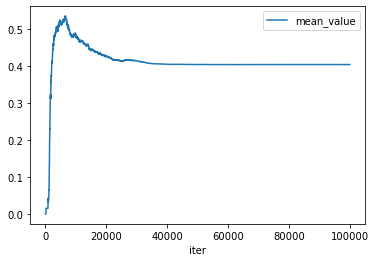

In [241]:
results[prob]['small']['q_learning']['gamma'].query('run==1 and gamma==.99').plot('iter', 'mean_value');

In [ ]:
results[prob]['small']['q_learning']['gamma'].query('run==1 and gamma==.9999').plot('iter', 'mean_value');

0.5


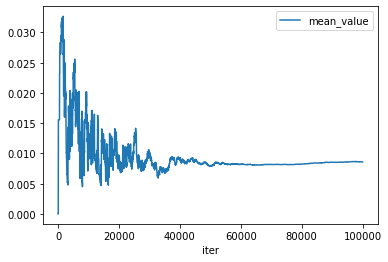

0.9


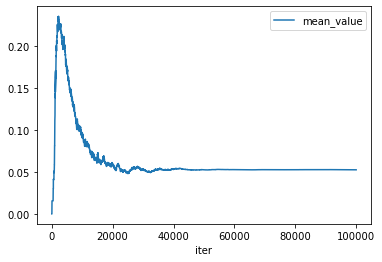

0.99


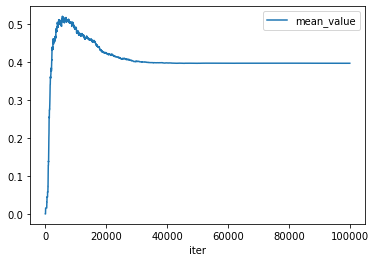

0.999


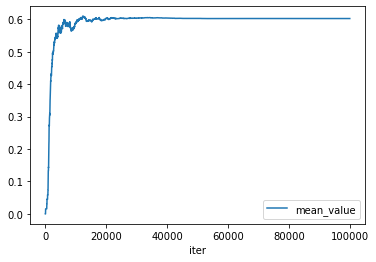

0.9999


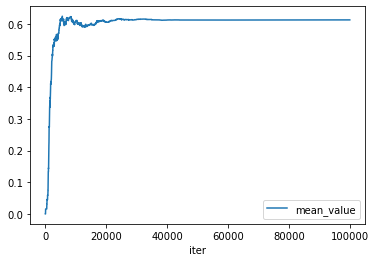

0.99999


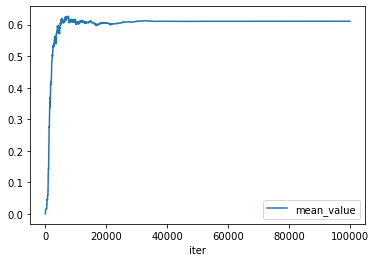

In [242]:
for g in sorted(gammas):
    print(g)
    results[prob][size][method][param].query(
        'gamma==@g and run==2'
    ).plot('iter', 'mean_value')
    plt.show()

In [243]:
# Q - alpha tuning
method = 'q_learning'
size = 'small'
param = 'alpha'
results[prob].setdefault(size, {})
results[prob][size].setdefault(method, {})
policies[prob].setdefault(size, {})
policies[prob][size].setdefault(method, {})
policies[prob][size][method].setdefault(param, {})
g = .99999
runs = range(5)
a_0 = 1
alpha_mins = [.1, .01, .001, .0001, .00001]
alpha_decays = [.999, .9999, .99999, .999999]
e_0 = 1
e = .9999
iter_callback = lambda x, y, z: envs[size].desc[z//sizes[size], z%sizes[size]] in b'GH'
df = []
for a in alpha_decays:
    policies[prob][size][method][param].setdefault(a, {})
    for a_min in alpha_mins:
        policies[prob][size][method][param][a].setdefault(a_min, {})
#         n_iter = int(max(1e4, 2*np.log(a_min)/np.log(a)))
        n_iter = int(4e6)
        for i in runs:
            print(f'Alpha Decay: {a} \tAlpha Min: {a_min} \tRun: {i}')
            np.random.seed(42*i)
            QL = mdp.QLearning(
                P[size],
                R_true[size],
                gamma=g,
                alpha=a_0,
                alpha_decay=a,
                alpha_min=a_min,
                epsilon=e_0,
                epsilon_decay=e,
                iter_callback=iter_callback,
                n_iter=n_iter
            )
            scores = QL.run()
            for r in scores:
                df.append((
                    prob, size, method, g, i, r['Epsilon'], e, r['Alpha'], a, a_min, r['Iteration'], r['Time'],
                    r['Mean V'], r['Error']
                ))
            policies[prob][size][method][param][a][a_min][i] = [p.copy() for _, p in QL.p_cumulative]
cols = [
    'prob', 'size', 'method', 'gamma', 'run', 'epsilon', 'epsilon_decay', 'alpha', 'alpha_decay', 'alpha_min', 'iter',
    'time', 'mean_value', 'error'
]
df = pd.DataFrame(df, columns=cols)
results[prob][size][method][param] = df.copy()

Alpha Decay: 0.999 	Alpha Min: 0.1 	Run: 0
Alpha Decay: 0.999 	Alpha Min: 0.1 	Run: 1
Alpha Decay: 0.999 	Alpha Min: 0.1 	Run: 2
Alpha Decay: 0.999 	Alpha Min: 0.1 	Run: 3
Alpha Decay: 0.999 	Alpha Min: 0.1 	Run: 4
Alpha Decay: 0.999 	Alpha Min: 0.01 	Run: 0
Alpha Decay: 0.999 	Alpha Min: 0.01 	Run: 1
Alpha Decay: 0.999 	Alpha Min: 0.01 	Run: 2
Alpha Decay: 0.999 	Alpha Min: 0.01 	Run: 3
Alpha Decay: 0.999 	Alpha Min: 0.01 	Run: 4
Alpha Decay: 0.999 	Alpha Min: 0.001 	Run: 0
Alpha Decay: 0.999 	Alpha Min: 0.001 	Run: 1
Alpha Decay: 0.999 	Alpha Min: 0.001 	Run: 2
Alpha Decay: 0.999 	Alpha Min: 0.001 	Run: 3
Alpha Decay: 0.999 	Alpha Min: 0.001 	Run: 4
Alpha Decay: 0.999 	Alpha Min: 0.0001 	Run: 0
Alpha Decay: 0.999 	Alpha Min: 0.0001 	Run: 1
Alpha Decay: 0.999 	Alpha Min: 0.0001 	Run: 2
Alpha Decay: 0.999 	Alpha Min: 0.0001 	Run: 3
Alpha Decay: 0.999 	Alpha Min: 0.0001 	Run: 4
Alpha Decay: 0.999 	Alpha Min: 1e-05 	Run: 0
Alpha Decay: 0.999 	Alpha Min: 1e-05 	Run: 1
Alpha Decay: 0.999 	

In [244]:
simulations[prob].setdefault(size, {})
simulations[prob][size].setdefault(method, {})
df = []
n = 1000
for a in alpha_decays:
    for a_min in alpha_mins:
        print(f'Alpha Decay: {a} \tAlpha Min: {a_min}')
        for i in runs:
            r = simulate_frozen_lake_policy(P[size], policies[prob][size][method][param][a][a_min][i][-1], n, 42*i)
            df.append((prob, size, method, a, a_min, i, sum(r)/n))
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'alpha_decay', 'alpha_min', 'run', 'avg_reward'])
simulations[prob][size][method][param] = df.copy()

Alpha Decay: 0.999 	Alpha Min: 0.1
Alpha Decay: 0.999 	Alpha Min: 0.01
Alpha Decay: 0.999 	Alpha Min: 0.001
Alpha Decay: 0.999 	Alpha Min: 0.0001
Alpha Decay: 0.999 	Alpha Min: 1e-05
Alpha Decay: 0.9999 	Alpha Min: 0.1
Alpha Decay: 0.9999 	Alpha Min: 0.01
Alpha Decay: 0.9999 	Alpha Min: 0.001
Alpha Decay: 0.9999 	Alpha Min: 0.0001
Alpha Decay: 0.9999 	Alpha Min: 1e-05
Alpha Decay: 0.99999 	Alpha Min: 0.1
Alpha Decay: 0.99999 	Alpha Min: 0.01
Alpha Decay: 0.99999 	Alpha Min: 0.001
Alpha Decay: 0.99999 	Alpha Min: 0.0001
Alpha Decay: 0.99999 	Alpha Min: 1e-05
Alpha Decay: 0.999999 	Alpha Min: 0.1
Alpha Decay: 0.999999 	Alpha Min: 0.01
Alpha Decay: 0.999999 	Alpha Min: 0.001
Alpha Decay: 0.999999 	Alpha Min: 0.0001
Alpha Decay: 0.999999 	Alpha Min: 1e-05


In [245]:
df.groupby(['alpha_decay', 'alpha_min'])['avg_reward'].describe()

count    mean       std    min    25%    50%    75%  \
alpha_decay alpha_min                                                        
0.999000    0.00001      5.0  0.0928  0.093623  0.010  0.029  0.047  0.147   
            0.00010      5.0  0.0970  0.090463  0.010  0.047  0.050  0.147   
            0.00100      5.0  0.1046  0.085160  0.030  0.055  0.057  0.146   
            0.01000      5.0  0.5418  0.385802  0.126  0.338  0.338  0.939   
            0.10000      5.0  0.9568  0.010232  0.940  0.955  0.960  0.963   
0.999900    0.00001      5.0  0.9610  0.013323  0.939  0.960  0.963  0.971   
            0.00010      5.0  0.9608  0.013293  0.939  0.960  0.962  0.971   
            0.00100      5.0  0.9628  0.012617  0.941  0.965  0.965  0.971   
            0.01000      5.0  0.9666  0.005771  0.960  0.961  0.969  0.970   
            0.10000      5.0  0.9568  0.005891  0.951  0.952  0.955  0.962   
0.999990    0.00001      5.0  0.9626  0.006656  0.955  0.960  0.961  0.964   
            0.00010      5.0  0.9626  0.006656  0.955  0.960  0.961  0.964   
            0.00100      5.0  0.9630  0.007969  0.955  0.955  0.964  0.968   
            0.01000      5.0  0.9662  0.005263  0.957  0.967  0.968  0.969   
            0.10000      5.0  0.9506  0.026745  0.903  0.959  0.961  0.964   
0.999999    0.00001      5.0  0.9676  0.004615  0.964  0.964  0.965  0.971   
            0.00010      5.0  0.9676  0.004615  0.964  0.964  0.965  0.971   
            0.00100      5.0  0.9676  0.004615  0.964  0.964  0.965  0.971   
            0.01000      5.0  0.9676  0.004615  0.964  0.964  0.965  0.971   
            0.10000      5.0  0.9634  0.008019  0.955  0.957  0.962  0.969   

                         max  
alpha_decay alpha_min         
0.999000    0.00001    0.231  
            0.00010    0.231  
            0.00100    0.235  
            0.01000    0.968  
            0.10000    0.966  
0.999900    0.00001    0.972  
            0.00010    0.972  
            0.00100    0.972  
            0.01000    0.973  
            0.10000    0.964  
0.999990    0.00001    0.973  
            0.00010    0.973  
            0.00100    0.973  
            0.01000    0.970  
            0.10000    0.966  
0.999999    0.00001    0.974  
            0.00010    0.974  
            0.00100    0.974  
            0.01000    0.974  
            0.10000    0.974

In [320]:
envs['small'].render()
for i in range(5):
    print(i)
    diff = np.where(
        policies[prob]['small']['q_learning']['alpha'][.99999][.01][i][-1].reshape(8,8) !=
        policies[prob]['small']['q_learning']['alpha'][.999999][.00001][4][-1].reshape(8,8)
    )
    for r, c in zip(*diff):
        if envs['small'].desc[r][c] in (b'HG'):
            continue
        a1 = policies[prob]['small']['q_learning']['alpha'][.99999][.01][i][-1].reshape(8,8)[r][c]
        a2 = policies[prob]['small']['q_learning']['alpha'][.999999][.00001][4][-1].reshape(8,8)[r][c]
        a1_diff, a2_diff = action_diffs(a1, a2) 
        l1 = move((r, c), a1_diff, 'small')
        l2 = move((r, c), a2_diff, 'small')
        if envs['small'].desc[l1] == b'H' and envs['small'].desc[l2] == b'H':
            continue
        print(
            (r,c), 
            action_map[policies[prob]['small']['q_learning']['alpha'][.99999][.01][i][-1].reshape(8,8)[r][c]],
            action_map[policies[prob]['small']['q_learning']['alpha'][.999999][.00001][4][-1].reshape(8,8)[r][c]]
        )
    print('')


SFFHFHFF
FHFFFFFF
HFFFFFFF
HFFFFFFF
FFFFFFFF
HFFFFFFF
HHFHHFHF
HHFFFFHG
0

1
(4, 4) ^ >
(4, 5) ^ >

2
(3, 3) ^ >
(4, 4) ^ >
(5, 2) > ^

3
(0, 4) v <
(3, 3) ^ >
(4, 0) > v

4
(4, 5) ^ >



0.999 1e-05


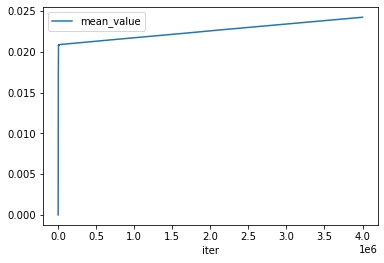

0.999 0.0001


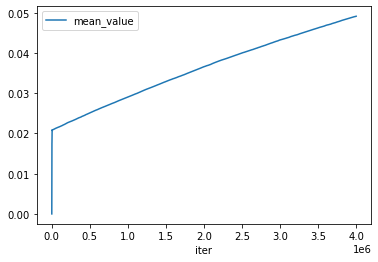

0.999 0.001


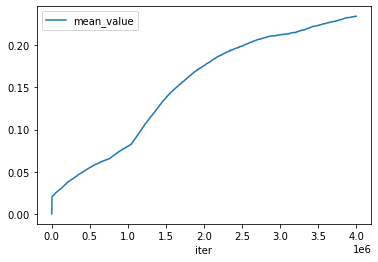

0.999 0.01


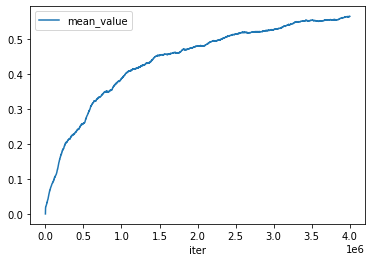

0.999 0.1


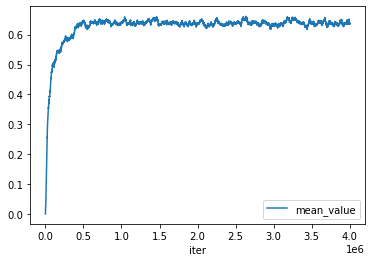

0.9999 1e-05


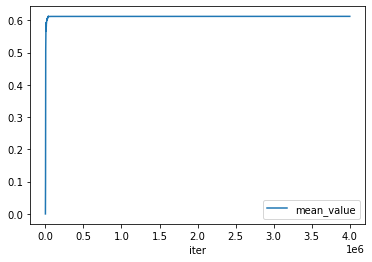

0.9999 0.0001


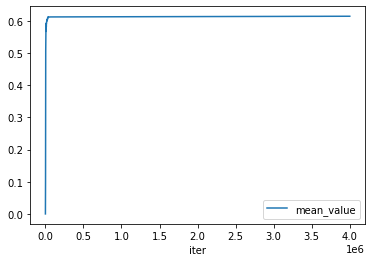

0.9999 0.001


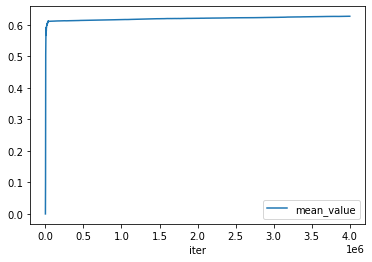

0.9999 0.01


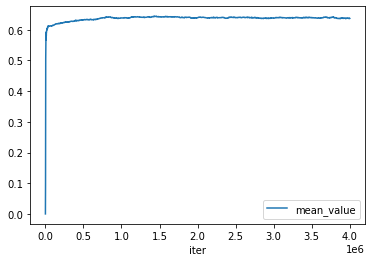

0.9999 0.1


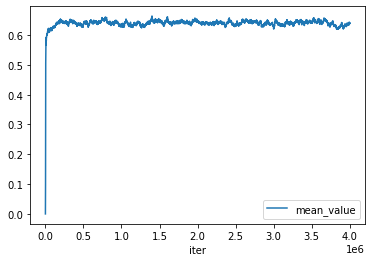

0.99999 1e-05


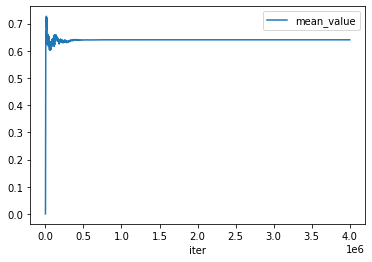

0.99999 0.0001


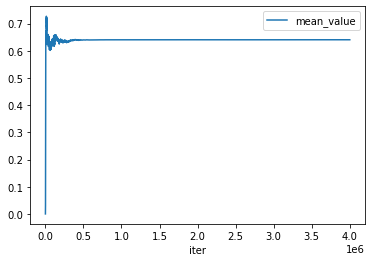

0.99999 0.001


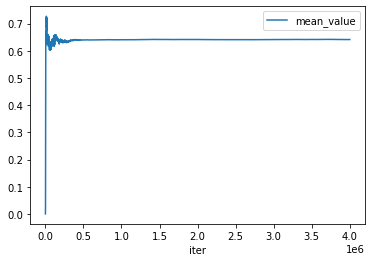

0.99999 0.01


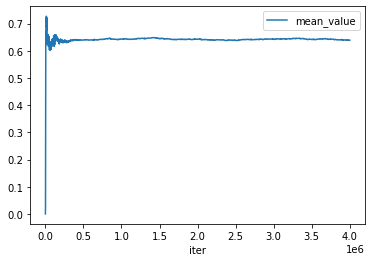

0.99999 0.1


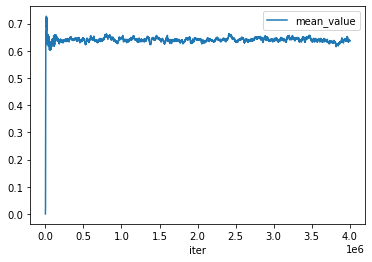

0.999999 1e-05


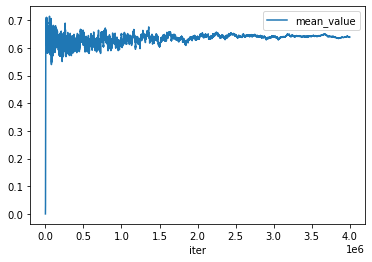

0.999999 0.0001


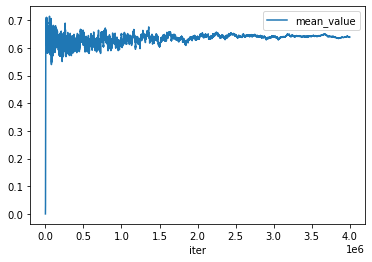

0.999999 0.001


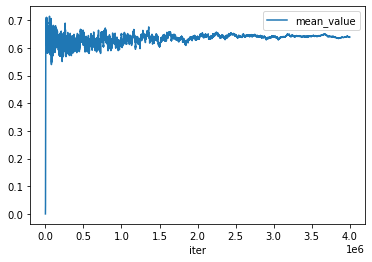

0.999999 0.01


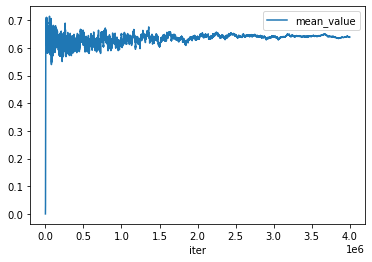

0.999999 0.1


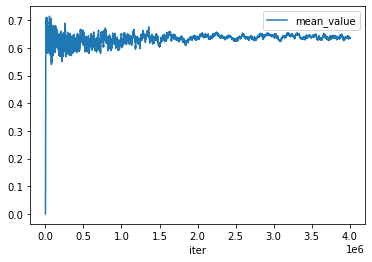

In [246]:
for a in sorted(df['alpha_decay'].unique()):
    for a_min in sorted(df['alpha_min'].unique()):
        print(a, a_min)
        results[prob][size][method][param].query(
            'alpha_decay==@a and alpha_min==@a_min and run==4'
        ).plot('iter', 'mean_value')
        plt.show()

In [401]:
# Q - epsilon tuning
method = 'q_learning'
size = 'small'
param = 'epsilon'
results[prob].setdefault(size, {})
results[prob][size].setdefault(method, {})
policies[prob].setdefault(size, {})
policies[prob][size].setdefault(method, {})
policies[prob][size][method].setdefault(param, {})
g = .99999
runs = range(5)
a_0 = 1
a_min = 1e-5
a = 0.99999
e_0 = 1
epsilon_decays = [.99, .999, .9999, .99999, .999999]
epsilon_mins = [.5, .3, .1, .05, .01]
iter_callback = lambda x, y, z: envs[size].desc[z//sizes[size], z%sizes[size]] in b'GH'
df = []
for e in epsilon_decays:
    policies[prob][size][method][param].setdefault(e, {})
    for e_min in epsilon_mins:
        policies[prob][size][method][param][e].setdefault(e_min, {})
#         n_iter = int(max(1e4, 2*np.log(a_min)/np.log(a), 2*np.log(e_min)/np.log(e)))
        n_iter = int(1e6)
        for i in runs:
            print(f'Epsilon Decay: {e} \tEpsilon Min: {e_min} \tRun: {i}')
            np.random.seed(42*i)
            QL = mdp.QLearning(
                P[size],
                R_true[size],
                gamma=g,
                alpha=a_0,
                alpha_decay=a,
                alpha_min=a_min,
                epsilon=e_0,
                epsilon_decay=e,
                epsilon_min=e_min,
                iter_callback=iter_callback,
                n_iter=n_iter
            )
            scores = QL.run()
            for r in scores:
                df.append((
                    prob, size, method, g, i, r['Epsilon'], e, e_min, r['Alpha'], a, a_min, r['Iteration'], r['Time'],
                    r['Mean V'], r['Error']
                ))
            policies[prob][size][method][param][e][e_min][i] = [p.copy() for _, p in QL.p_cumulative]
cols = [
    'prob', 'size', 'method', 'gamma', 'run', 'epsilon', 'epsilon_decay', 'epsilon_min', 'alpha', 'alpha_decay',
    'alpha_min', 'iter', 'time', 'mean_value', 'error'
]
df = pd.DataFrame(df, columns=cols)
results[prob][size][method][param] = df.copy()

Epsilon Decay: 0.99 	Epsilon Min: 0.5 	Run: 0
Epsilon Decay: 0.99 	Epsilon Min: 0.5 	Run: 1
Epsilon Decay: 0.99 	Epsilon Min: 0.5 	Run: 2
Epsilon Decay: 0.99 	Epsilon Min: 0.5 	Run: 3
Epsilon Decay: 0.99 	Epsilon Min: 0.5 	Run: 4
Epsilon Decay: 0.99 	Epsilon Min: 0.3 	Run: 0
Epsilon Decay: 0.99 	Epsilon Min: 0.3 	Run: 1
Epsilon Decay: 0.99 	Epsilon Min: 0.3 	Run: 2
Epsilon Decay: 0.99 	Epsilon Min: 0.3 	Run: 3
Epsilon Decay: 0.99 	Epsilon Min: 0.3 	Run: 4
Epsilon Decay: 0.99 	Epsilon Min: 0.1 	Run: 0
Epsilon Decay: 0.99 	Epsilon Min: 0.1 	Run: 1
Epsilon Decay: 0.99 	Epsilon Min: 0.1 	Run: 2
Epsilon Decay: 0.99 	Epsilon Min: 0.1 	Run: 3
Epsilon Decay: 0.99 	Epsilon Min: 0.1 	Run: 4
Epsilon Decay: 0.99 	Epsilon Min: 0.05 	Run: 0
Epsilon Decay: 0.99 	Epsilon Min: 0.05 	Run: 1
Epsilon Decay: 0.99 	Epsilon Min: 0.05 	Run: 2
Epsilon Decay: 0.99 	Epsilon Min: 0.05 	Run: 3
Epsilon Decay: 0.99 	Epsilon Min: 0.05 	Run: 4
Epsilon Decay: 0.99 	Epsilon Min: 0.01 	Run: 0
Epsilon Decay: 0.99 	Epsilon

In [402]:
simulations[prob].setdefault(size, {})
simulations[prob][size].setdefault(method, {})
df = []
n = 1000
for e in epsilon_decays:
    for e_min in epsilon_mins:
        print(f'Epsilon Decay: {e} \tEpsilon Min: {e_min}')
        for i in runs:
            r = simulate_frozen_lake_policy(P[size], policies[prob][size][method][param][e][e_min][i][-1], n, 42*i)
            df.append((prob, size, method, e, e_min, i, sum(r)/n))
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'epsilon_decay', 'epsilon_min', 'run', 'avg_reward'])
simulations[prob][size][method][param] = df.copy()

Epsilon Decay: 0.99 	Epsilon Min: 0.5
Epsilon Decay: 0.99 	Epsilon Min: 0.3
Epsilon Decay: 0.99 	Epsilon Min: 0.1
Epsilon Decay: 0.99 	Epsilon Min: 0.05
Epsilon Decay: 0.99 	Epsilon Min: 0.01
Epsilon Decay: 0.999 	Epsilon Min: 0.5
Epsilon Decay: 0.999 	Epsilon Min: 0.3
Epsilon Decay: 0.999 	Epsilon Min: 0.1
Epsilon Decay: 0.999 	Epsilon Min: 0.05
Epsilon Decay: 0.999 	Epsilon Min: 0.01
Epsilon Decay: 0.9999 	Epsilon Min: 0.5
Epsilon Decay: 0.9999 	Epsilon Min: 0.3
Epsilon Decay: 0.9999 	Epsilon Min: 0.1
Epsilon Decay: 0.9999 	Epsilon Min: 0.05
Epsilon Decay: 0.9999 	Epsilon Min: 0.01
Epsilon Decay: 0.99999 	Epsilon Min: 0.5
Epsilon Decay: 0.99999 	Epsilon Min: 0.3
Epsilon Decay: 0.99999 	Epsilon Min: 0.1
Epsilon Decay: 0.99999 	Epsilon Min: 0.05
Epsilon Decay: 0.99999 	Epsilon Min: 0.01
Epsilon Decay: 0.999999 	Epsilon Min: 0.5
Epsilon Decay: 0.999999 	Epsilon Min: 0.3
Epsilon Decay: 0.999999 	Epsilon Min: 0.1
Epsilon Decay: 0.999999 	Epsilon Min: 0.05
Epsilon Decay: 0.999999 	Epsilon 

In [403]:
df.groupby(['epsilon_decay', 'epsilon_min'])['avg_reward'].describe()

count    mean       std    min    25%    50%  \
epsilon_decay epsilon_min                                                 
0.990000      0.01           5.0  0.0854  0.041579  0.029  0.073  0.081   
              0.05           5.0  0.7838  0.387344  0.091  0.949  0.952   
              0.10           5.0  0.9644  0.002881  0.960  0.964  0.965   
              0.30           5.0  0.9656  0.003912  0.960  0.965  0.966   
              0.50           5.0  0.9698  0.005891  0.962  0.965  0.973   
0.999000      0.01           5.0  0.0992  0.035131  0.060  0.075  0.095   
              0.05           5.0  0.6448  0.438477  0.159  0.170  0.962   
              0.10           5.0  0.9666  0.008792  0.957  0.958  0.969   
              0.30           5.0  0.9684  0.005079  0.965  0.965  0.966   
              0.50           5.0  0.9668  0.009783  0.950  0.968  0.969   
0.999900      0.01           5.0  0.9408  0.015579  0.924  0.928  0.943   
              0.05           5.0  0.9584  0.008019  0.945  0.958  0.961   
              0.10           5.0  0.9626  0.006656  0.955  0.960  0.961   
              0.30           5.0  0.9662  0.002775  0.963  0.965  0.965   
              0.50           5.0  0.9692  0.001643  0.968  0.968  0.969   
0.999990      0.01           5.0  0.9624  0.005177  0.958  0.959  0.961   
              0.05           5.0  0.9650  0.003674  0.962  0.962  0.965   
              0.10           5.0  0.9680  0.005385  0.961  0.965  0.968   
              0.30           5.0  0.9700  0.004301  0.965  0.968  0.968   
              0.50           5.0  0.9700  0.006205  0.963  0.964  0.972   
0.999999      0.01           5.0  0.9646  0.004827  0.957  0.964  0.965   
              0.05           5.0  0.9646  0.004827  0.957  0.964  0.965   
              0.10           5.0  0.9646  0.004827  0.957  0.964  0.965   
              0.30           5.0  0.9646  0.004827  0.957  0.964  0.965   
              0.50           5.0  0.9650  0.005831  0.957  0.963  0.965   

                             75%    max  
epsilon_decay epsilon_min                
0.990000      0.01         0.101  0.143  
              0.05         0.962  0.965  
              0.10         0.965  0.968  
              0.30         0.966  0.971  
              0.50         0.974  0.975  
0.999000      0.01         0.117  0.149  
              0.05         0.964  0.969  
              0.10         0.972  0.977  
              0.30         0.969  0.977  
              0.50         0.972  0.975  
0.999900      0.01         0.946  0.963  
              0.05         0.962  0.966  
              0.10         0.964  0.973  
              0.30         0.968  0.970  
              0.50         0.969  0.972  
0.999990      0.01         0.963  0.971  
              0.05         0.965  0.971  
              0.10         0.971  0.975  
              0.30         0.974  0.975  
              0.50         0.974  0.977  
0.999999      0.01         0.967  0.970  
              0.05         0.967  0.970  
              0.10         0.967  0.970  
              0.30         0.967  0.970  
              0.50         0.967  0.973

In [404]:
np.array(list(map(lambda x: action_map[x], QL.policy))).reshape((8, 8))

array([['^', '^', '<', '<', '>', '<', '>', '>'],
       ['^', '<', '>', 'v', 'v', 'v', '>', '>'],
       ['<', 'v', '>', '>', '>', '>', '>', '>'],
       ['<', '>', '>', '>', '>', '>', '>', '>'],
       ['v', '>', '>', '>', '^', '>', '>', '>'],
       ['<', '^', '^', '^', '^', '^', '^', '>'],
       ['<', '<', '<', '<', '<', '<', '<', '>'],
       ['<', '<', '>', 'v', 'v', '<', '<', '<']], dtype='<U1')

In [405]:
np.array(QL.V).round(2).reshape((8, 8))

array([[0.98, 0.98, 0.98, 0.  , 0.49, 0.  , 1.  , 1.  ],
       [0.51, 0.  , 0.97, 0.98, 0.99, 0.99, 1.  , 1.  ],
       [0.  , 0.55, 0.96, 0.98, 0.99, 1.  , 1.  , 1.  ],
       [0.  , 0.71, 0.93, 0.97, 0.98, 0.99, 1.  , 1.  ],
       [0.36, 0.68, 0.86, 0.94, 0.97, 0.99, 1.  , 1.  ],
       [0.  , 0.47, 0.73, 0.87, 0.94, 0.97, 0.99, 1.  ],
       [0.  , 0.  , 0.37, 0.  , 0.  , 0.49, 0.  , 1.  ],
       [0.  , 0.  , 0.43, 0.47, 0.49, 0.49, 0.  , 0.  ]])

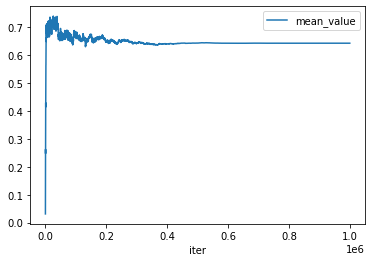

In [406]:
results[prob][size][method][param].query(
    'run==0 and epsilon_min==0.5 and epsilon_decay==0.999'
).plot('iter', 'mean_value');

0.99 0.01


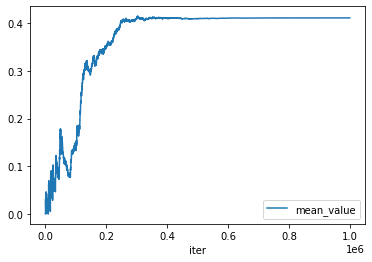

0.99 0.05


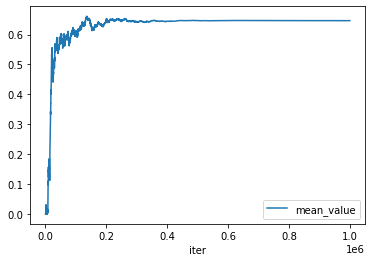

0.99 0.1


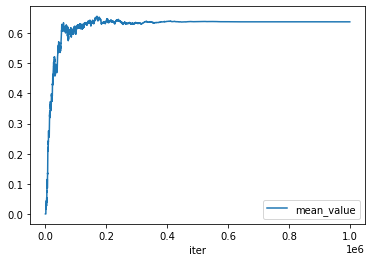

0.99 0.3


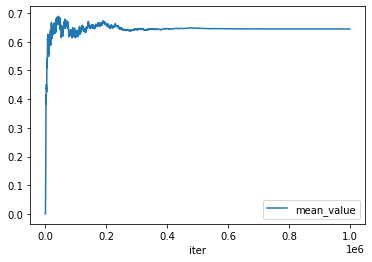

0.99 0.5


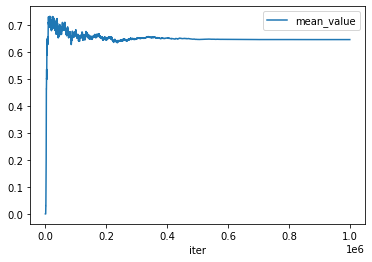

0.999 0.01


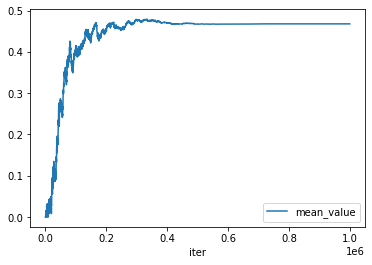

0.999 0.05


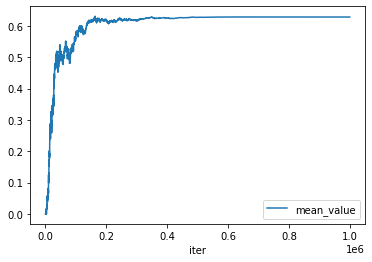

0.999 0.1


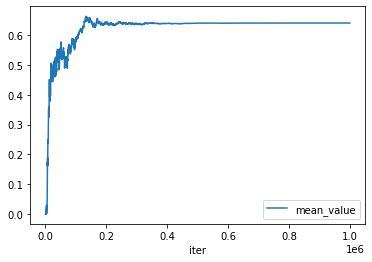

0.999 0.3


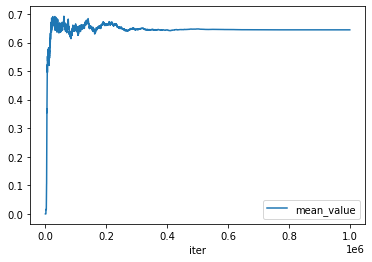

0.999 0.5


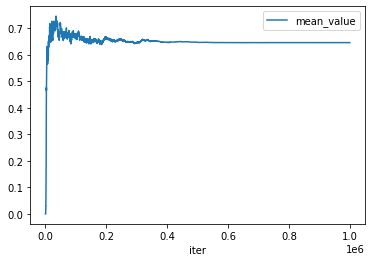

0.9999 0.01


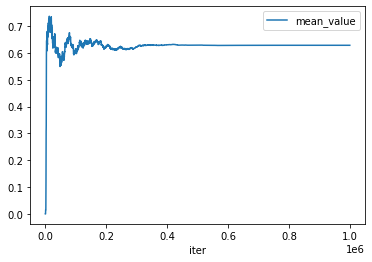

0.9999 0.05


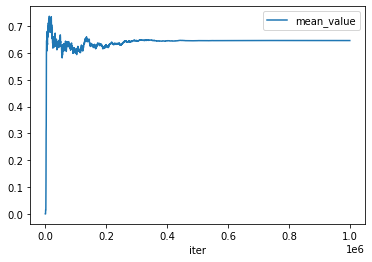

0.9999 0.1


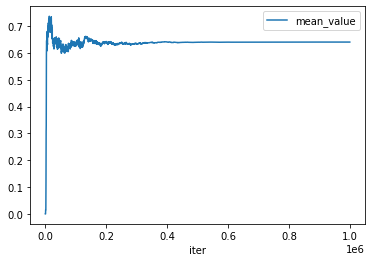

0.9999 0.3


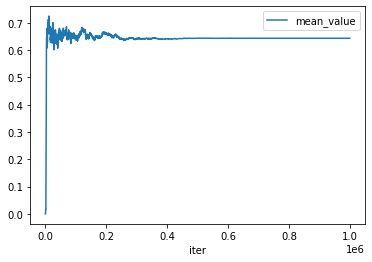

0.9999 0.5


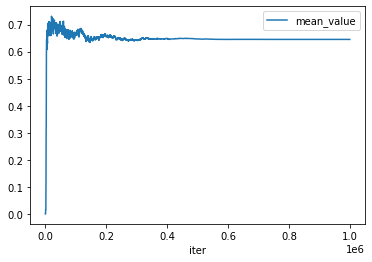

0.99999 0.01


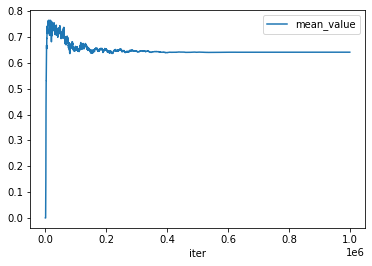

0.99999 0.05


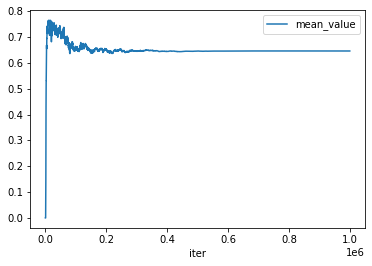

0.99999 0.1


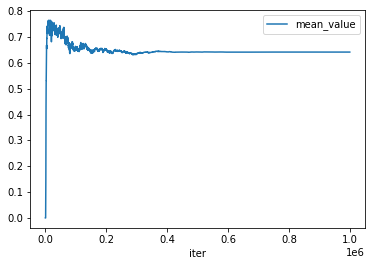

0.99999 0.3


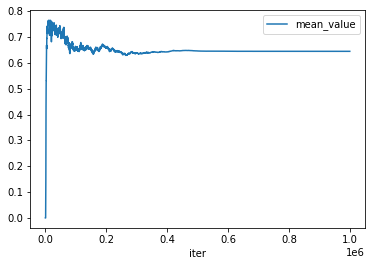

0.99999 0.5


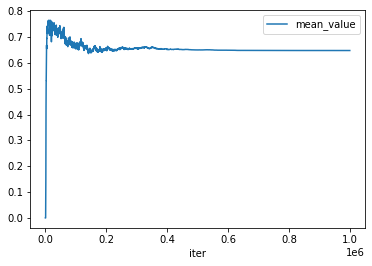

0.999999 0.01


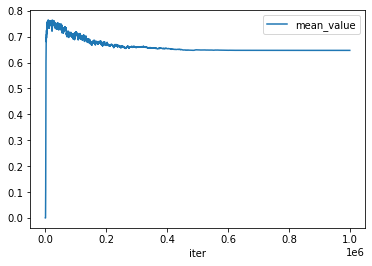

0.999999 0.05


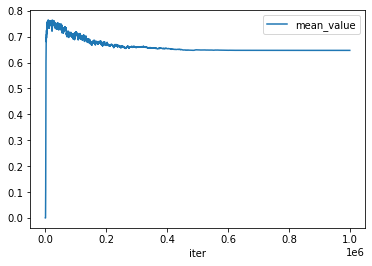

0.999999 0.1


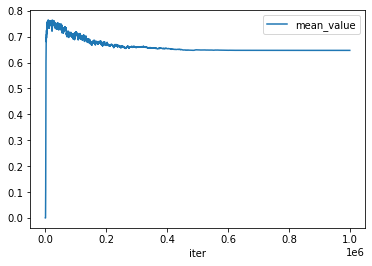

0.999999 0.3


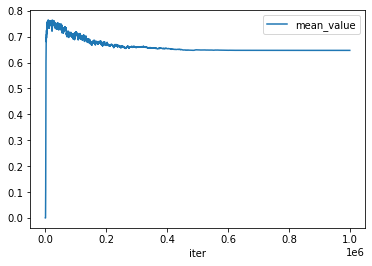

0.999999 0.5


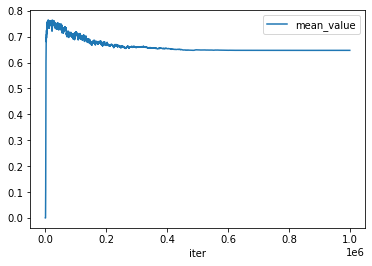

In [407]:
for e in sorted(df['epsilon_decay'].unique()):
    for e_min in sorted(df['epsilon_min'].unique()):
        print(e, e_min)
        results[prob][size][method][param].query(
            'epsilon_decay==@e and epsilon_min==@e_min and run==4'
        ).plot('iter', 'mean_value')
        plt.show()

In [114]:
# Q Learning - gamma tuning
method = 'q_learning'
size = 'large'
param = 'gamma'
results[prob].setdefault(size, {})
results[prob][size].setdefault(method, {})
policies[prob].setdefault(size, {})
policies[prob][size].setdefault(method, {})
policies[prob][size][method].setdefault(param, {})
n_iter = int(4e6)
gammas = [.5, .9, .99, .999, .9999, .99999]
runs = range(5)
a_0 = 1
a = .999999
e_0 = 1
e = .999999
iter_callback = lambda x, y, z: envs[size].desc[z//sizes[size], z%sizes[size]] in b'GH'
df = []
for g in gammas:
    policies[prob][size][method][param].setdefault(g, {})
    for i in runs:
        print(f'Gamma: {g} \tRun: {i}')
        np.random.seed(42*i)
        QL = mdp.QLearning(
            P[size],
            R_true[size],
            gamma=g,
            alpha=a_0,
            alpha_decay=a,
            epsilon=e_0,
            epsilon_decay=e,
            iter_callback=iter_callback,
            n_iter=n_iter
        )
        scores = QL.run()
        for r in scores:
            df.append((
                prob, size, method, g, i, r['Epsilon'], e, r['Alpha'], a, r['Iteration'], r['Time'], r['Mean V'],
                r['Error']
            ))
        policies[prob][size][method][param][g][i] = [p.copy() for _, p in QL.p_cumulative]
cols = [
    'prob', 'size', 'method', 'gamma', 'run', 'epsilon', 'epsilon_decay', 'alpha', 'alpha_decay', 'iter', 'time',
    'mean_value', 'error'
]
df = pd.DataFrame(df, columns=cols)
results[prob][size][method][param] = df.copy()

Gamma: 0.5 	Run: 0
Gamma: 0.5 	Run: 1
Gamma: 0.5 	Run: 2
Gamma: 0.5 	Run: 3
Gamma: 0.5 	Run: 4
Gamma: 0.9 	Run: 0
Gamma: 0.9 	Run: 1
Gamma: 0.9 	Run: 2
Gamma: 0.9 	Run: 3
Gamma: 0.9 	Run: 4
Gamma: 0.99 	Run: 0
Gamma: 0.99 	Run: 1
Gamma: 0.99 	Run: 2
Gamma: 0.99 	Run: 3
Gamma: 0.99 	Run: 4
Gamma: 0.999 	Run: 0
Gamma: 0.999 	Run: 1
Gamma: 0.999 	Run: 2
Gamma: 0.999 	Run: 3
Gamma: 0.999 	Run: 4
Gamma: 0.9999 	Run: 0
Gamma: 0.9999 	Run: 1
Gamma: 0.9999 	Run: 2
Gamma: 0.9999 	Run: 3
Gamma: 0.9999 	Run: 4
Gamma: 0.99999 	Run: 0
Gamma: 0.99999 	Run: 1
Gamma: 0.99999 	Run: 2
Gamma: 0.99999 	Run: 3
Gamma: 0.99999 	Run: 4


In [115]:
simulations[prob].setdefault(size, {})
simulations[prob][size].setdefault(method, {})
df = []
n = 1000
for g in gammas:
    print(f'Gamma: {g}')
    for i in runs:
        r = simulate_frozen_lake_policy(P[size], policies[prob][size][method][param][g][i][-1], n, 42*i)
        df.append((prob, size, method, g, i, sum(r)/n))
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'gamma', 'run', 'avg_reward'])
simulations[prob][size][method][param] = df.copy()

Gamma: 0.5
Gamma: 0.9
Gamma: 0.99
Gamma: 0.999
Gamma: 0.9999
Gamma: 0.99999


In [116]:
df.groupby('gamma')['avg_reward'].describe()

,count,mean,std,min,25%,50%,75%,max
gamma,,,,,,,,
0.50000,5.0,0.0004,0.000894,0.000,0.000,0.000,0.000,0.002
0.90000,5.0,0.0560,0.031432,0.014,0.034,0.064,0.078,0.090
0.99000,5.0,0.1516,0.013315,0.131,0.146,0.157,0.160,0.164
0.99900,5.0,0.3186,0.010310,0.307,0.313,0.314,0.329,0.330
0.99990,5.0,0.3262,0.043350,0.253,0.325,0.341,0.347,0.365
0.99999,5.0,0.3136,0.015662,0.296,0.306,0.311,0.317,0.338


0.5


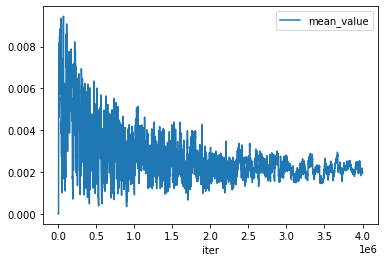

0.9


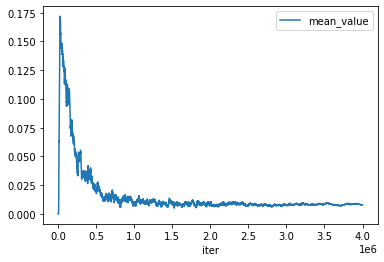

0.99


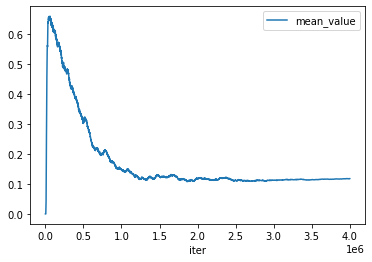

0.999


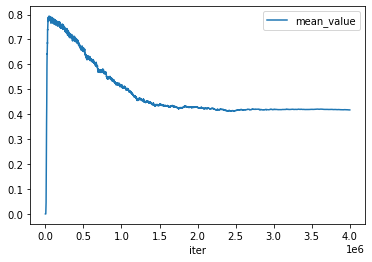

0.9999


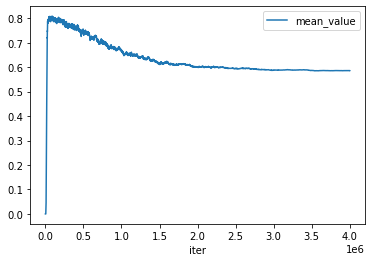

0.99999


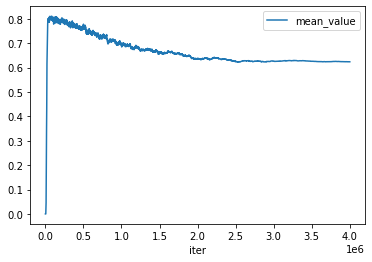

In [138]:
for g in sorted(gammas):
    print(g)
    results[prob][size][method][param].query(
        'gamma==@g and run==0'
    ).plot('iter', 'mean_value')
    plt.show()

In [142]:
for i in np.array(VI.V).round(1).reshape((16, 16)):
    print(i)

[0.3 0.3 0.3 0.3 0.3 0.3 0.  0.7 0.7 0.7 0.4 0.  0.  1.  1.  1. ]
[0.3 0.3 0.3 0.3 0.3 0.2 0.  0.6 0.7 0.7 0.  0.5 0.8 1.  1.  1. ]
[0.3 0.3 0.3 0.3 0.3 0.  0.2 0.5 0.7 0.7 0.4 0.6 0.9 1.  1.  1. ]
[0.3 0.3 0.  0.3 0.3 0.1 0.  0.  0.7 0.7 0.  0.5 0.9 1.  1.  0. ]
[0.  0.3 0.3 0.3 0.3 0.  0.  0.4 0.7 0.7 0.5 0.  1.  1.  1.  1. ]
[0.3 0.3 0.3 0.3 0.3 0.4 0.5 0.6 0.7 0.7 0.7 0.  1.  1.  1.  1. ]
[0.2 0.2 0.  0.2 0.  0.3 0.4 0.6 0.7 0.7 0.9 0.9 0.9 1.  1.  1. ]
[0.  0.  0.  0.3 0.3 0.  0.3 0.  0.  0.  0.9 0.9 0.  1.  1.  1. ]
[0.  0.1 0.4 0.5 0.5 0.  0.5 0.4 0.  0.6 0.9 1.  1.  1.  0.  0. ]
[0.  0.  0.6 0.6 0.6 0.8 0.8 0.7 0.  0.8 0.9 1.  1.  1.  1.  1. ]
[0.5 0.4 0.7 0.7 0.  0.9 0.9 0.9 0.9 0.9 0.9 1.  1.  1.  1.  1. ]
[0.6 0.  0.8 0.8 0.6 0.9 0.9 1.  1.  0.  0.  1.  1.  1.  1.  1. ]
[0.7 0.9 0.9 0.9 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
[0.  0.9 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.9 0.8 0.6 0. ]
[1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  0.  0.6 0.  0. ]
[1.  1.  1

In [137]:
for i in np.array(QL.V).round(1).reshape((16, 16)):
    print(i)

[0.5 0.5 0.5 0.5 0.5 0.4 0.  0.7 0.7 0.7 0.4 0.  0.  1.  1.  1. ]
[0.5 0.5 0.5 0.5 0.5 0.3 0.  0.6 0.7 0.7 0.  0.5 0.8 1.  1.  1. ]
[0.5 0.5 0.5 0.5 0.5 0.  0.2 0.5 0.7 0.7 0.5 0.6 0.9 1.  1.  1. ]
[0.5 0.5 0.  0.5 0.5 0.2 0.  0.  0.7 0.7 0.  0.6 0.9 1.  1.  0. ]
[0.  0.4 0.4 0.4 0.4 0.  0.  0.4 0.7 0.7 0.4 0.  1.  1.  1.  1. ]
[0.4 0.4 0.4 0.4 0.4 0.4 0.5 0.6 0.7 0.7 0.7 0.  1.  1.  1.  1. ]
[0.3 0.2 0.  0.3 0.  0.3 0.5 0.6 0.7 0.7 0.9 0.9 1.  1.  1.  1. ]
[0.  0.  0.  0.3 0.2 0.  0.3 0.  0.  0.  0.9 0.9 0.  1.  1.  1. ]
[0.  0.2 0.4 0.5 0.5 0.  0.5 0.4 0.  0.6 0.9 1.  1.  1.  0.  0. ]
[0.  0.  0.6 0.7 0.6 0.8 0.8 0.7 0.  0.8 1.  1.  1.  1.  1.  1. ]
[0.6 0.4 0.7 0.7 0.  0.9 0.9 0.9 0.9 0.9 0.9 1.  1.  1.  1.  1. ]
[0.7 0.  0.8 0.8 0.6 0.9 0.9 1.  1.  0.  0.  1.  1.  1.  1.  1. ]
[0.8 0.9 0.9 0.9 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
[0.  0.9 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.9 0.9 0.6 0. ]
[1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  0.  0.7 0.  0. ]
[1.  1.  1

In [143]:
# Q - alpha tuning
method = 'q_learning'
size = 'large'
param = 'alpha'
results[prob].setdefault(size, {})
results[prob][size].setdefault(method, {})
policies[prob].setdefault(size, {})
policies[prob][size].setdefault(method, {})
policies[prob][size][method].setdefault(param, {})
g = .9999
runs = range(5)
a_0 = 1
alpha_mins = [.01, .001, .0001, .00001]
alpha_decays = [.999, .9999, .99999, .999999]
e_0 = 1
e = .999999
iter_callback = lambda x, y, z: envs[size].desc[z//sizes[size], z%sizes[size]] in b'GH'
df = []
for a in alpha_decays:
    policies[prob][size][method][param].setdefault(a, {})
    for a_min in alpha_mins:
        policies[prob][size][method][param][a].setdefault(a_min, {})
#         n_iter = int(max(1e4, 2*np.log(a_min)/np.log(a)))
        n_iter = int(4e6)
        for i in runs:
            print(f'Alpha Decay: {a} \tAlpha Min: {a_min} \tRun: {i}')
            np.random.seed(42*i)
            QL = mdp.QLearning(
                P[size],
                R_true[size],
                gamma=g,
                alpha=a_0,
                alpha_decay=a,
                alpha_min=a_min,
                epsilon=e_0,
                epsilon_decay=e,
                iter_callback=iter_callback,
                n_iter=n_iter
            )
            scores = QL.run()
            for r in scores:
                df.append((
                    prob, size, method, g, i, r['Epsilon'], e, r['Alpha'], a, a_min, r['Iteration'], r['Time'],
                    r['Mean V'], r['Error']
                ))
            policies[prob][size][method][param][a][a_min][i] = [p.copy() for _, p in QL.p_cumulative]
cols = [
    'prob', 'size', 'method', 'gamma', 'run', 'epsilon', 'epsilon_decay', 'alpha', 'alpha_decay', 'alpha_min', 'iter',
    'time', 'mean_value', 'error'
]
df = pd.DataFrame(df, columns=cols)
results[prob][size][method][param] = df.copy()

Alpha Decay: 0.999 	Alpha Min: 0.01 	Run: 0
Alpha Decay: 0.999 	Alpha Min: 0.01 	Run: 1
Alpha Decay: 0.999 	Alpha Min: 0.01 	Run: 2
Alpha Decay: 0.999 	Alpha Min: 0.01 	Run: 3
Alpha Decay: 0.999 	Alpha Min: 0.01 	Run: 4
Alpha Decay: 0.999 	Alpha Min: 0.001 	Run: 0
Alpha Decay: 0.999 	Alpha Min: 0.001 	Run: 1
Alpha Decay: 0.999 	Alpha Min: 0.001 	Run: 2
Alpha Decay: 0.999 	Alpha Min: 0.001 	Run: 3
Alpha Decay: 0.999 	Alpha Min: 0.001 	Run: 4
Alpha Decay: 0.999 	Alpha Min: 0.0001 	Run: 0
Alpha Decay: 0.999 	Alpha Min: 0.0001 	Run: 1
Alpha Decay: 0.999 	Alpha Min: 0.0001 	Run: 2
Alpha Decay: 0.999 	Alpha Min: 0.0001 	Run: 3
Alpha Decay: 0.999 	Alpha Min: 0.0001 	Run: 4
Alpha Decay: 0.999 	Alpha Min: 1e-05 	Run: 0
Alpha Decay: 0.999 	Alpha Min: 1e-05 	Run: 1
Alpha Decay: 0.999 	Alpha Min: 1e-05 	Run: 2
Alpha Decay: 0.999 	Alpha Min: 1e-05 	Run: 3
Alpha Decay: 0.999 	Alpha Min: 1e-05 	Run: 4
Alpha Decay: 0.9999 	Alpha Min: 0.01 	Run: 0
Alpha Decay: 0.9999 	Alpha Min: 0.01 	Run: 1
Alpha Deca

In [144]:
simulations[prob].setdefault(size, {})
simulations[prob][size].setdefault(method, {})
df = []
n = 1000
for a in alpha_decays:
    for a_min in alpha_mins:
        print(f'Alpha Decay: {a} \tAlpha Min: {a_min}')
        for i in runs:
            r = simulate_frozen_lake_policy(P[size], policies[prob][size][method][param][a][a_min][i][-1], n, 42*i)
            df.append((prob, size, method, a, a_min, i, sum(r)/n))
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'alpha_decay', 'alpha_min', 'run', 'avg_reward'])
simulations[prob][size][method][param] = df.copy()

Alpha Decay: 0.999 	Alpha Min: 0.01
Alpha Decay: 0.999 	Alpha Min: 0.001
Alpha Decay: 0.999 	Alpha Min: 0.0001
Alpha Decay: 0.999 	Alpha Min: 1e-05
Alpha Decay: 0.9999 	Alpha Min: 0.01
Alpha Decay: 0.9999 	Alpha Min: 0.001
Alpha Decay: 0.9999 	Alpha Min: 0.0001
Alpha Decay: 0.9999 	Alpha Min: 1e-05
Alpha Decay: 0.99999 	Alpha Min: 0.01
Alpha Decay: 0.99999 	Alpha Min: 0.001
Alpha Decay: 0.99999 	Alpha Min: 0.0001
Alpha Decay: 0.99999 	Alpha Min: 1e-05
Alpha Decay: 0.999999 	Alpha Min: 0.01
Alpha Decay: 0.999999 	Alpha Min: 0.001
Alpha Decay: 0.999999 	Alpha Min: 0.0001
Alpha Decay: 0.999999 	Alpha Min: 1e-05


In [145]:
df.groupby(['alpha_decay', 'alpha_min'])['avg_reward'].describe()

count    mean       std    min    25%    50%    75%  \
alpha_decay alpha_min                                                        
0.999000    0.00001      5.0  0.0000  0.000000  0.000  0.000  0.000  0.000   
            0.00010      5.0  0.0000  0.000000  0.000  0.000  0.000  0.000   
            0.00100      5.0  0.0002  0.000447  0.000  0.000  0.000  0.000   
            0.01000      5.0  0.0018  0.002168  0.000  0.000  0.001  0.003   
0.999900    0.00001      5.0  0.0002  0.000447  0.000  0.000  0.000  0.000   
            0.00010      5.0  0.0004  0.000894  0.000  0.000  0.000  0.000   
            0.00100      5.0  0.0010  0.002236  0.000  0.000  0.000  0.000   
            0.01000      5.0  0.0172  0.007662  0.009  0.013  0.014  0.022   
0.999990    0.00001      5.0  0.3184  0.033246  0.263  0.314  0.333  0.334   
            0.00010      5.0  0.3058  0.017427  0.291  0.293  0.298  0.315   
            0.00100      5.0  0.2772  0.038226  0.226  0.252  0.282  0.312   
            0.01000      5.0  0.2882  0.035379  0.229  0.287  0.300  0.303   
0.999999    0.00001      5.0  0.3262  0.043350  0.253  0.325  0.341  0.347   
            0.00010      5.0  0.3262  0.043350  0.253  0.325  0.341  0.347   
            0.00100      5.0  0.3262  0.043350  0.253  0.325  0.341  0.347   
            0.01000      5.0  0.3262  0.043350  0.253  0.325  0.341  0.347   

                         max  
alpha_decay alpha_min         
0.999000    0.00001    0.000  
            0.00010    0.000  
            0.00100    0.001  
            0.01000    0.005  
0.999900    0.00001    0.001  
            0.00010    0.002  
            0.00100    0.005  
            0.01000    0.028  
0.999990    0.00001    0.348  
            0.00010    0.332  
            0.00100    0.314  
            0.01000    0.322  
0.999999    0.00001    0.365  
            0.00010    0.365  
            0.00100    0.365  
            0.01000    0.365

0.999 1e-05


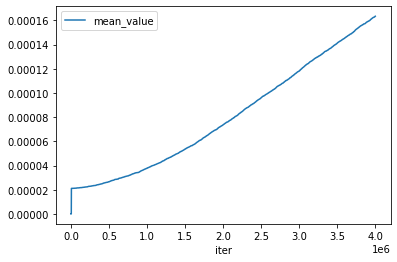

0.999 0.0001


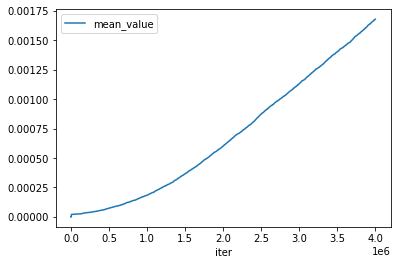

0.999 0.001


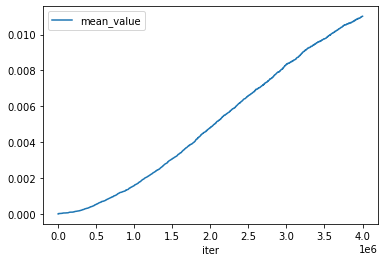

0.999 0.01


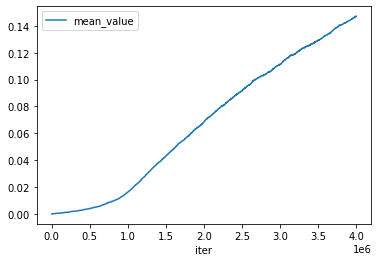

0.9999 1e-05


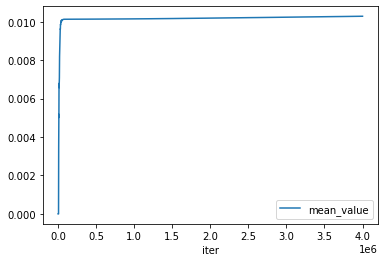

0.9999 0.0001


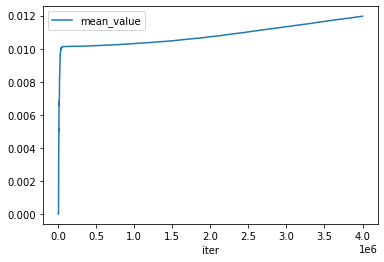

0.9999 0.001


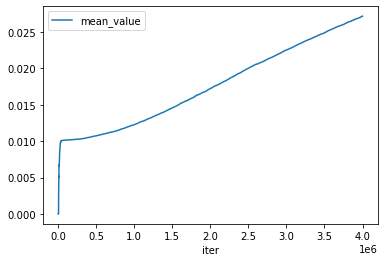

0.9999 0.01


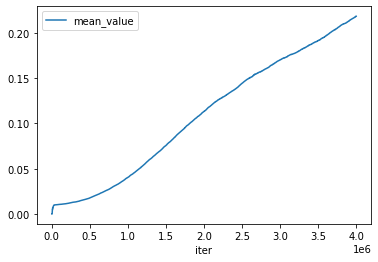

0.99999 1e-05


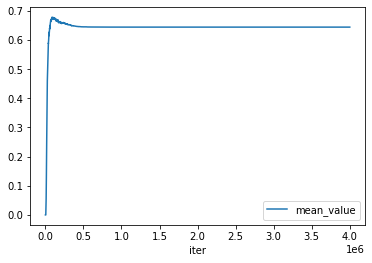

0.99999 0.0001


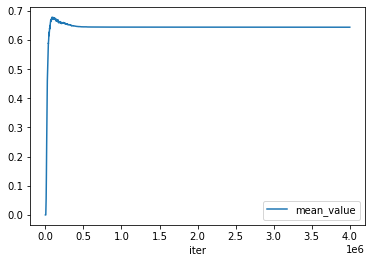

0.99999 0.001


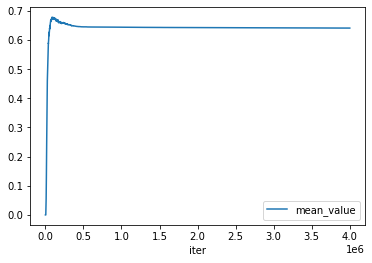

0.99999 0.01


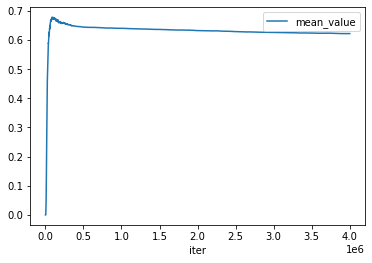

0.999999 1e-05


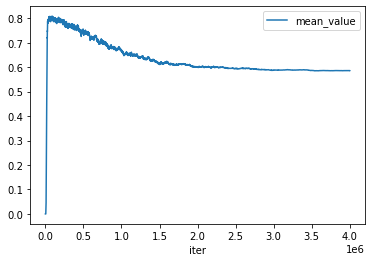

0.999999 0.0001


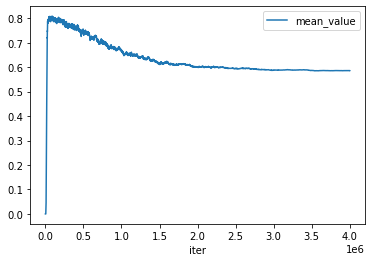

0.999999 0.001


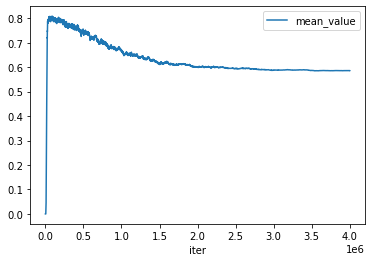

0.999999 0.01


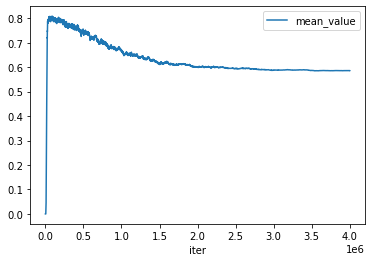

In [146]:
for a in sorted(df['alpha_decay'].unique()):
    for a_min in sorted(df['alpha_min'].unique()):
        print(a, a_min)
        results[prob][size][method][param].query(
            'alpha_decay==@a and alpha_min==@a_min and run==0'
        ).plot('iter', 'mean_value')
        plt.show()

In [148]:
# Q - epsilon tuning
method = 'q_learning'
size = 'large'
param = 'epsilon'
results[prob].setdefault(size, {})
results[prob][size].setdefault(method, {})
policies[prob].setdefault(size, {})
policies[prob][size].setdefault(method, {})
policies[prob][size][method].setdefault(param, {})
g = .9999
runs = range(5)
a_0 = 1
a_min = 1e-5
a = .999999
e_0 = 1
epsilon_decays = [.99, .999, .9999, .99999, .999999]
epsilon_mins = [.5, .3, .1, .05, .01]
iter_callback = lambda x, y, z: envs[size].desc[z//sizes[size], z%sizes[size]] in b'GH'
df = []
for e in epsilon_decays:
    policies[prob][size][method][param].setdefault(e, {})
    for e_min in epsilon_mins:
        policies[prob][size][method][param][e].setdefault(e_min, {})
#         n_iter = int(max(1e4, 2*np.log(a_min)/np.log(a), 2*np.log(e_min)/np.log(e)))
        n_iter = int(1e7)
        for i in runs:
            print(f'Epsilon Decay: {e} \tEpsilon Min: {e_min} \tRun: {i}')
            np.random.seed(42*i)
            QL = mdp.QLearning(
                P[size],
                R_true[size],
                gamma=g,
                alpha=a_0,
                alpha_decay=a,
                alpha_min=a_min,
                epsilon=e_0,
                epsilon_decay=e,
                epsilon_min=e_min,
                iter_callback=iter_callback,
                n_iter=n_iter
            )
            scores = QL.run()
            for r in scores:
                df.append((
                    prob, size, method, g, i, r['Epsilon'], e, e_min, r['Alpha'], a, a_min, r['Iteration'], r['Time'],
                    r['Mean V'], r['Error']
                ))
            policies[prob][size][method][param][e][e_min][i] = [p.copy() for _, p in QL.p_cumulative]
cols = [
    'prob', 'size', 'method', 'gamma', 'run', 'epsilon', 'epsilon_decay', 'epsilon_min', 'alpha', 'alpha_decay',
    'alpha_min', 'iter', 'time', 'mean_value', 'error'
]
df = pd.DataFrame(df, columns=cols)
results[prob][size][method][param] = df.copy()

Epsilon Decay: 0.99 	Epsilon Min: 0.5 	Run: 0
Epsilon Decay: 0.99 	Epsilon Min: 0.5 	Run: 1
Epsilon Decay: 0.99 	Epsilon Min: 0.5 	Run: 2
Epsilon Decay: 0.99 	Epsilon Min: 0.5 	Run: 3
Epsilon Decay: 0.99 	Epsilon Min: 0.5 	Run: 4
Epsilon Decay: 0.99 	Epsilon Min: 0.3 	Run: 0
Epsilon Decay: 0.99 	Epsilon Min: 0.3 	Run: 1
Epsilon Decay: 0.99 	Epsilon Min: 0.3 	Run: 2
Epsilon Decay: 0.99 	Epsilon Min: 0.3 	Run: 3
Epsilon Decay: 0.99 	Epsilon Min: 0.3 	Run: 4
Epsilon Decay: 0.99 	Epsilon Min: 0.1 	Run: 0
Epsilon Decay: 0.99 	Epsilon Min: 0.1 	Run: 1
Epsilon Decay: 0.99 	Epsilon Min: 0.1 	Run: 2
Epsilon Decay: 0.99 	Epsilon Min: 0.1 	Run: 3
Epsilon Decay: 0.99 	Epsilon Min: 0.1 	Run: 4
Epsilon Decay: 0.99 	Epsilon Min: 0.05 	Run: 0
Epsilon Decay: 0.99 	Epsilon Min: 0.05 	Run: 1
Epsilon Decay: 0.99 	Epsilon Min: 0.05 	Run: 2
Epsilon Decay: 0.99 	Epsilon Min: 0.05 	Run: 3
Epsilon Decay: 0.99 	Epsilon Min: 0.05 	Run: 4
Epsilon Decay: 0.99 	Epsilon Min: 0.01 	Run: 0
Epsilon Decay: 0.99 	Epsilon

In [149]:
simulations[prob].setdefault(size, {})
simulations[prob][size].setdefault(method, {})
df = []
n = 1000
for e in epsilon_decays:
    for e_min in epsilon_mins:
        print(f'Epsilon Decay: {e} \tEpsilon Min: {e_min}')
        for i in runs:
            r = simulate_frozen_lake_policy(P[size], policies[prob][size][method][param][e][e_min][i][-1], n, 42*i)
            df.append((prob, size, method, e, e_min, i, sum(r)/n))
df = pd.DataFrame(df, columns=['prob', 'size', 'method', 'epsilon_decay', 'epsilon_min', 'run', 'avg_reward'])
simulations[prob][size][method][param] = df.copy()

Epsilon Decay: 0.99 	Epsilon Min: 0.5
Epsilon Decay: 0.99 	Epsilon Min: 0.3
Epsilon Decay: 0.99 	Epsilon Min: 0.1
Epsilon Decay: 0.99 	Epsilon Min: 0.05
Epsilon Decay: 0.99 	Epsilon Min: 0.01
Epsilon Decay: 0.999 	Epsilon Min: 0.5
Epsilon Decay: 0.999 	Epsilon Min: 0.3
Epsilon Decay: 0.999 	Epsilon Min: 0.1
Epsilon Decay: 0.999 	Epsilon Min: 0.05
Epsilon Decay: 0.999 	Epsilon Min: 0.01
Epsilon Decay: 0.9999 	Epsilon Min: 0.5
Epsilon Decay: 0.9999 	Epsilon Min: 0.3
Epsilon Decay: 0.9999 	Epsilon Min: 0.1
Epsilon Decay: 0.9999 	Epsilon Min: 0.05
Epsilon Decay: 0.9999 	Epsilon Min: 0.01
Epsilon Decay: 0.99999 	Epsilon Min: 0.5
Epsilon Decay: 0.99999 	Epsilon Min: 0.3
Epsilon Decay: 0.99999 	Epsilon Min: 0.1
Epsilon Decay: 0.99999 	Epsilon Min: 0.05
Epsilon Decay: 0.99999 	Epsilon Min: 0.01
Epsilon Decay: 0.999999 	Epsilon Min: 0.5
Epsilon Decay: 0.999999 	Epsilon Min: 0.3
Epsilon Decay: 0.999999 	Epsilon Min: 0.1
Epsilon Decay: 0.999999 	Epsilon Min: 0.05
Epsilon Decay: 0.999999 	Epsilon 

In [150]:
df.groupby(['epsilon_decay', 'epsilon_min'])['avg_reward'].describe()

count    mean       std    min    25%    50%  \
epsilon_decay epsilon_min                                                 
0.990000      0.01           5.0  0.0050  0.010100  0.000  0.000  0.000   
              0.05           5.0  0.3106  0.036205  0.261  0.299  0.301   
              0.10           5.0  0.3396  0.015566  0.323  0.328  0.335   
              0.30           5.0  0.3364  0.007893  0.330  0.331  0.331   
              0.50           5.0  0.3056  0.018609  0.286  0.291  0.302   
0.999000      0.01           5.0  0.0000  0.000000  0.000  0.000  0.000   
              0.05           5.0  0.3160  0.031678  0.268  0.302  0.329   
              0.10           5.0  0.3382  0.018390  0.315  0.330  0.332   
              0.30           5.0  0.3384  0.013520  0.322  0.329  0.337   
              0.50           5.0  0.3076  0.012462  0.294  0.298  0.305   
0.999900      0.01           5.0  0.0022  0.002387  0.000  0.001  0.001   
              0.05           5.0  0.3296  0.013975  0.308  0.323  0.338   
              0.10           5.0  0.3424  0.006877  0.333  0.340  0.343   
              0.30           5.0  0.3508  0.014618  0.332  0.348  0.350   
              0.50           5.0  0.3138  0.018926  0.296  0.300  0.312   
0.999990      0.01           5.0  0.3340  0.024729  0.305  0.313  0.336   
              0.05           5.0  0.3332  0.015023  0.308  0.334  0.337   
              0.10           5.0  0.3492  0.016784  0.334  0.336  0.349   
              0.30           5.0  0.3406  0.013957  0.324  0.332  0.337   
              0.50           5.0  0.3162  0.023296  0.295  0.303  0.304   
0.999999      0.01           5.0  0.3022  0.054692  0.220  0.272  0.333   
              0.05           5.0  0.3476  0.015421  0.333  0.339  0.339   
              0.10           5.0  0.3412  0.013293  0.324  0.330  0.349   
              0.30           5.0  0.3438  0.016739  0.324  0.334  0.339   
              0.50           5.0  0.3270  0.020211  0.301  0.313  0.328   

                             75%    max  
epsilon_decay epsilon_min                
0.990000      0.01         0.002  0.023  
              0.05         0.341  0.351  
              0.10         0.356  0.356  
              0.30         0.344  0.346  
              0.50         0.319  0.330  
0.999000      0.01         0.000  0.000  
              0.05         0.332  0.349  
              0.10         0.356  0.358  
              0.30         0.351  0.353  
              0.50         0.319  0.322  
0.999900      0.01         0.003  0.006  
              0.05         0.338  0.341  
              0.10         0.344  0.352  
              0.30         0.351  0.373  
              0.50         0.317  0.344  
0.999990      0.01         0.356  0.360  
              0.05         0.339  0.348  
              0.10         0.351  0.376  
              0.30         0.354  0.356  
              0.50         0.327  0.352  
0.999999      0.01         0.340  0.346  
              0.05         0.357  0.370  
              0.10         0.349  0.354  
              0.30         0.358  0.364  
              0.50         0.346  0.347

0.99 0.01


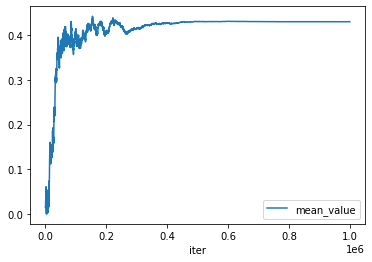

0.99 0.05


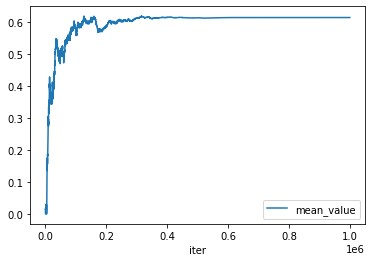

0.99 0.1


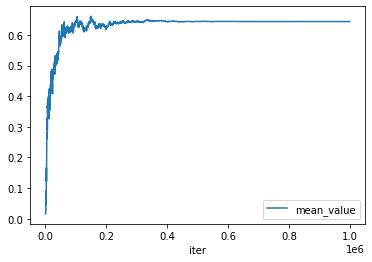

0.99 0.3


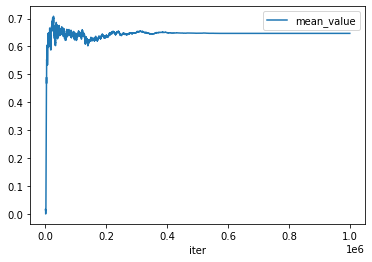

0.99 0.5


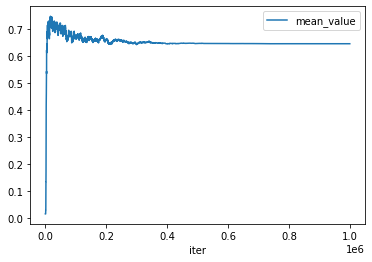

0.999 0.01


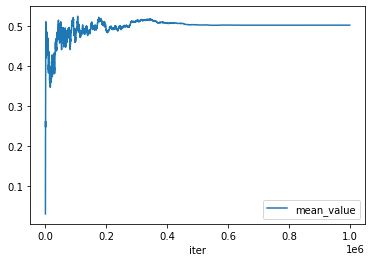

0.999 0.05


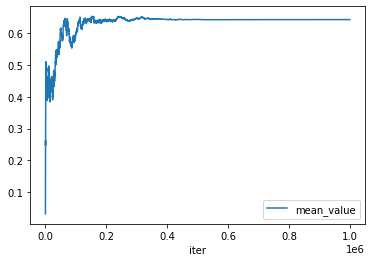

0.999 0.1


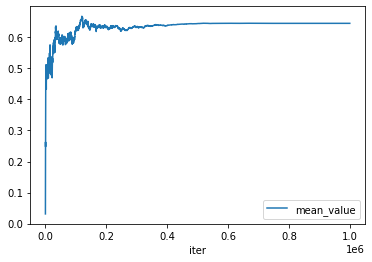

0.999 0.3


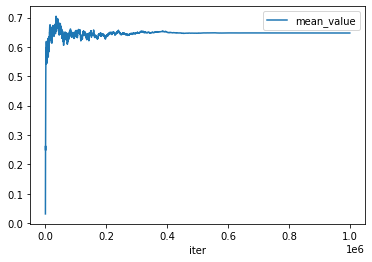

0.999 0.5


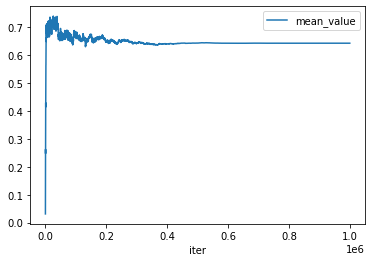

0.9999 0.01


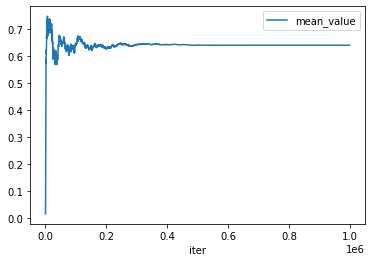

0.9999 0.05


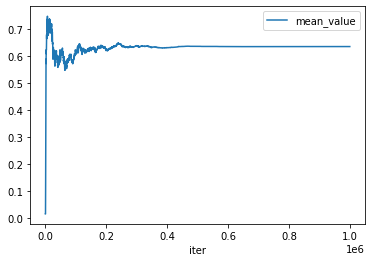

0.9999 0.1


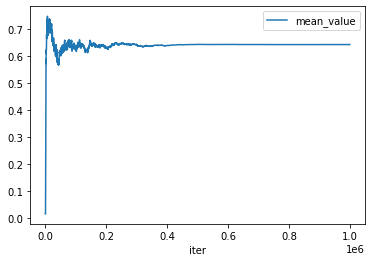

0.9999 0.3


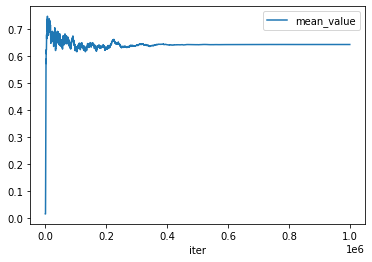

0.9999 0.5


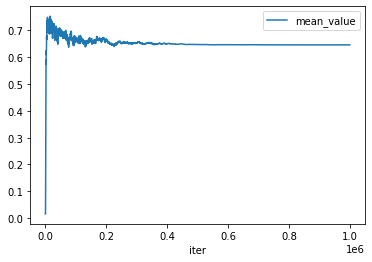

0.99999 0.01


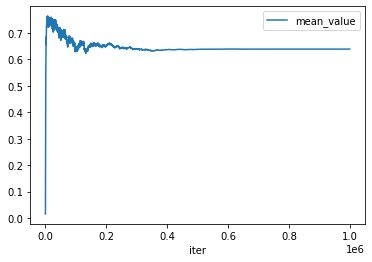

0.99999 0.05


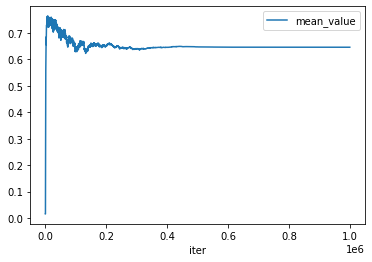

0.99999 0.1


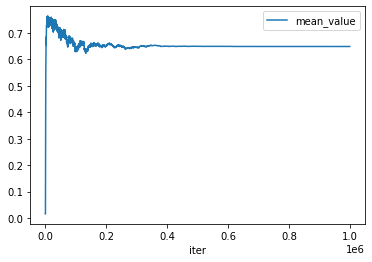

0.99999 0.3


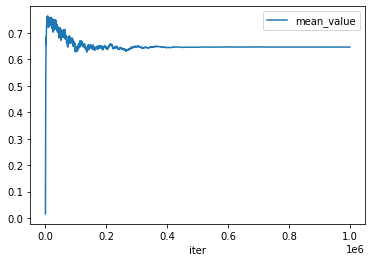

0.99999 0.5


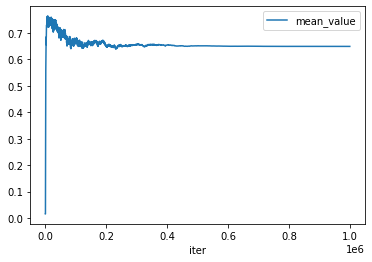

0.999999 0.01


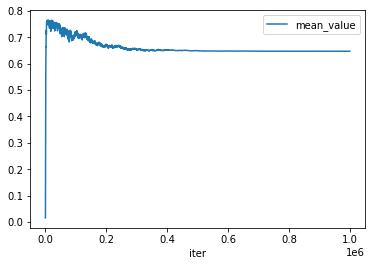

0.999999 0.05


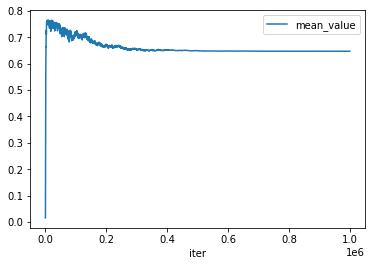

0.999999 0.1


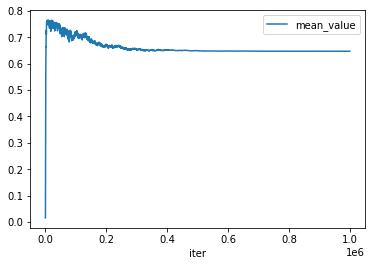

0.999999 0.3


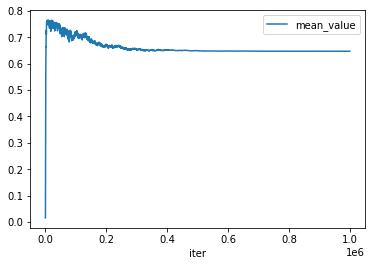

0.999999 0.5


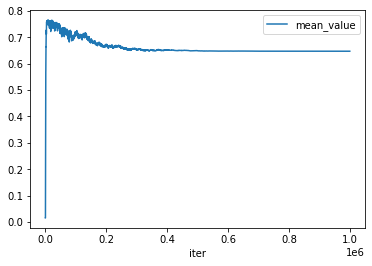

In [411]:
for e in sorted(df['epsilon_decay'].unique()):
    for e_min in sorted(df['epsilon_min'].unique()):
        print(e, e_min)
        results[prob][size][method][param].query(
            'epsilon_decay==@e and epsilon_min==@e_min and run==0'
        ).plot('iter', 'mean_value')
        plt.show()

In [409]:
save_results(results, folder='./results')
save_results(policies, folder='./policies')
save_results(simulations, folder='./simulations')